In [2]:
import math
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm
import networkx as nx
from ripser import ripser
from persim import plot_diagrams
import dionysus as d
from shapely.geometry import LineString
import random
from shapely.ops import unary_union
from tqdm import tqdm
import copy
import multiprocessing
from functools import partial
from collections import defaultdict
import matplotlib.colors as mcolors
from pathos.multiprocessing import ProcessingPool as Pool
from multiprocessing import get_context
from matplotlib.collections import PatchCollection
from shapely.geometry import MultiLineString
from scipy.stats import norm
from scipy.stats import skewnorm


from IPython.display import clear_output
#clear_output(wait=True)
import warnings
warnings.simplefilter('ignore')

In [3]:
state = 'IA'
stateCode = '19'

In [4]:
#http://wiki.gis.com/wiki/index.php/Federal_Information_Processing_Standard_state_code
#https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/TRACT/
gdf = gpd.read_file('tl_rd22_19_tract/tl_rd22_19_tract.shp')

In [5]:
gdf = gdf.to_crs("EPSG:4326")

<Axes: >

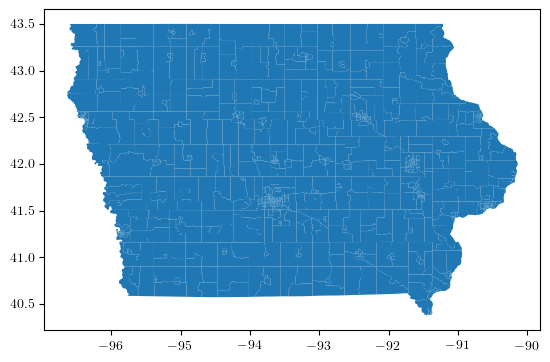

In [6]:
gdf.plot()

In [7]:
gdf = gdf[(~gdf['NAME'].str.startswith('99'))]

In [8]:
gdf.head(3)

STATEFP COUNTYFP TRACTCE        GEOID  NAME           NAMELSAD  MTFCC  \
0      19      055  950300  19055950300  9503  Census Tract 9503  G5020   
1      19      055  950400  19055950400  9504  Census Tract 9504  G5020   
2      19      055  950200  19055950200  9502  Census Tract 9502  G5020   

  FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S   27142261    64413  +42.4880514  -091.4603285   
1        S  735669629  2021640  +42.3756176  -091.3534927   
2        S  355629133   914273  +42.5591162  -091.4957852   

                                            geometry  
0  POLYGON ((-91.53625 42.49823, -91.53573 42.498...  
1  POLYGON ((-91.59784 42.38613, -91.59782 42.388...  
2  POLYGON ((-91.60906 42.55734, -91.60904 42.558...

In [9]:
gdf['tract_id'] = gdf['GEOID']

In [10]:
gdf.head(2)

STATEFP COUNTYFP TRACTCE        GEOID  NAME           NAMELSAD  MTFCC  \
0      19      055  950300  19055950300  9503  Census Tract 9503  G5020   
1      19      055  950400  19055950400  9504  Census Tract 9504  G5020   

  FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S   27142261    64413  +42.4880514  -091.4603285   
1        S  735669629  2021640  +42.3756176  -091.3534927   

                                            geometry     tract_id  
0  POLYGON ((-91.53625 42.49823, -91.53573 42.498...  19055950300  
1  POLYGON ((-91.59784 42.38613, -91.59782 42.388...  19055950400

In [11]:
#https://data.census.gov/table/DECENNIALDP2020.DP1?text=DP&g=010XX00US$1400000_040XX00US19$1400000
gdf_pop = pd.read_csv('DECENNIALDP2020.DP1_2023-10-02T223452/DECENNIALDP2020.DP1-Data.csv')
gdf_pop.head(2)

GEO_ID                                       NAME  \
0             Geography                       Geographic Area Name   
1  1400000US01001020100  Census Tract 201; Autauga County; Alabama   

                              DP1_0001C  \
0  Count!!SEX AND AGE!!Total population   
1                                  1775   

                                          DP1_0001CA  \
0  Annotation of Count!!SEX AND AGE!!Total popula...   
1                                                NaN   

                                           DP1_0002C  \
0  Count!!SEX AND AGE!!Total population!!Under 5 ...   
1                                                 97   

                                          DP1_0002CA  \
0  Annotation of Count!!SEX AND AGE!!Total popula...   
1                                                NaN   

                                           DP1_0003C  \
0  Count!!SEX AND AGE!!Total population!!5 to 9 y...   
1                                                101   

                                          DP1_0003CA  \
0  Annotation of Count!!SEX AND AGE!!Total popula...   
1                                                NaN   

                                           DP1_0004C  \
0  Count!!SEX AND AGE!!Total population!!10 to 14...   
1                                                136   

                                          DP1_0004CA  ...  \
0  Annotation of Count!!SEX AND AGE!!Total popula...  ...   
1                                                NaN  ...   

                                          DP1_0156PA  \
0  Annotation of Percent!!VACANCY RATES!!Homeowne...   
1                                                (X)   

                                           DP1_0157P  \
0  Percent!!VACANCY RATES!!Rental vacancy rate (p...   
1                                                (X)   

                                          DP1_0157PA  \
0  Annotation of Percent!!VACANCY RATES!!Rental v...   
1                                                (X)   

                                         DP1_0158P  \
0  Percent!!HOUSING TENURE!!Occupied housing units   
1                                            100.0   

                                          DP1_0158PA  \
0  Annotation of Percent!!HOUSING TENURE!!Occupie...   
1                                                NaN   

                                           DP1_0159P  \
0  Percent!!HOUSING TENURE!!Occupied housing unit...   
1                                               78.8   

                                          DP1_0159PA  \
0  Annotation of Percent!!HOUSING TENURE!!Occupie...   
1                                                NaN   

                                           DP1_0160P  \
0  Percent!!HOUSING TENURE!!Occupied housing unit...   
1                                               21.2   

                                          DP1_0160PA Unnamed: 642  
0  Annotation of Percent!!HOUSING TENURE!!Occupie...          NaN  
1                                                NaN          NaN  

[2 rows x 643 columns]

In [12]:
gdf_pop = gdf_pop[['GEO_ID', 'DP1_0001C']][1:]
gdf_pop.columns = ['GEO_ID', 'population']
gdf_pop['tract_id'] = gdf_pop['GEO_ID'].apply(lambda x: x.split('US')[1], 1)
gdf_pop.head(2)

GEO_ID population     tract_id
1  1400000US01001020100       1775  01001020100
2  1400000US01001020200       2055  01001020200

In [13]:
gdf_pop = gdf_pop[gdf_pop['tract_id'].str.startswith(stateCode)].drop_duplicates()
gdf_pop.head()

GEO_ID population     tract_id
29964  1400000US19001960100       2776  19001960100
29965  1400000US19001960200       1611  19001960200
29966  1400000US19001960300       3109  19001960300
29967  1400000US19003950100       1587  19003950100
29968  1400000US19003950200       2117  19003950200

In [14]:
gdf_pop.shape == gdf.shape

False

In [15]:
gdf_pop[['tract_id', 'population']]

tract_id population
29964  19001960100       2776
29965  19001960200       1611
29966  19001960300       3109
29967  19003950100       1587
29968  19003950200       2117
...            ...        ...
30855  19197680100       3450
30856  19197680200       1454
30857  19197680300       3202
30858  19197680400       1158
30859  19197680500       3679

[896 rows x 2 columns]

In [16]:
gdf = gdf.merge(gdf_pop[['tract_id', 'population']], how='left', on='tract_id')
gdf.sample(3)

STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
509      19      163  012801  19163012801  128.01  Census Tract 128.01  G5020   
404      19      125  030202  19125030202  302.02  Census Tract 302.02  G5020   
335      19      019  950100  19019950100    9501    Census Tract 9501  G5020   

    FUNCSTAT      ALAND  AWATER     INTPTLAT      INTPTLON  \
509        S    8109743       0  +41.5860676  -090.5800633   
404        S    6797007       0  +41.3943801  -092.9034267   
335        S  380709158   60302  +42.5494905  -091.7409300   

                                              geometry     tract_id population  
509  POLYGON ((-90.60019 41.58450, -90.60016 41.585...  19163012801       5062  
404  POLYGON ((-92.92876 41.40849, -92.92866 41.409...  19125030202       3166  
335  POLYGON ((-91.85541 42.52686, -91.85389 42.526...  19019950100       2374

In [17]:
# Load USPS locations
gdf_points = gpd.read_file('USPS DDUs_New1.csv')
# List to hold all GeoDataFrames
gdfs = [gdf_points]

# Loop to read the remaining files and append them to the list
for i in range(2, 24):
    file = 'USPS DDUs_New' + str(i) + '.csv'
    temp = gpd.read_file(file)
    gdfs.append(temp)

# Concatenate all GeoDataFrames in the list
gdf_points = pd.concat(gdfs, ignore_index=True)

In [18]:
gdf_points.head(1)

AREA_NAME DISTRICT_NAME LOCALE_NAME        ADDRESS        CITY STATE  \
0  SOUTHERN (G)         AL-MS  ADAMSVILLE  3609 GRAY AVE  ADAMSVILLE    AL   

  ZIP_CODE LOG_REGION_NAME LOG_DIVISION_NAME PROC_REGION_NAME  \
0    35005        SOUTHERN     GULF ATLANTIC          EASTERN   

  PROC_DIVISION_NAME Status Incident_Type Comment    LAST_EDITED_DATE  \
0      GULF ATLANTIC   OPEN                        5/9/2021, 12:04 PM   

  LAST_EDITED_USER              x             y geometry  
0           QQWFR0  -9677710.1021  3973674.5493     None

In [19]:
gdf_points['geometry'] = gpd.points_from_xy(gdf_points.x, gdf_points.y)
gdf_points.crs = "3857"

In [20]:
gdf_points = gdf_points.to_crs("EPSG:4326")

In [21]:
# selecting the state and making sure the post offices we look at are operational
gdf_points = gdf_points[(gdf_points['STATE'] == state) & (gdf_points['Status'] != 'CLOSED')]
gdf_points.head(2)

AREA_NAME DISTRICT_NAME LOCALE_NAME        ADDRESS     CITY STATE  \
6822  CENTRAL (J)      IA-NE-SD     ALLISON  307 N MAIN ST  ALLISON    IA   
6823  CENTRAL (J)      IA-NE-SD      ACKLEY    706 1ST AVE   ACKLEY    IA   

     ZIP_CODE LOG_REGION_NAME LOG_DIVISION_NAME PROC_REGION_NAME  \
6822    50602         CENTRAL           MIDWEST          WESTERN   
6823    50601         CENTRAL           MIDWEST          WESTERN   

     PROC_DIVISION_NAME Status Incident_Type Comment    LAST_EDITED_DATE  \
6822            MIDWEST   OPEN                        5/9/2021, 12:04 PM   
6823            MIDWEST   OPEN                        5/9/2021, 12:04 PM   

     LAST_EDITED_USER               x                   y  \
6822           QQWFR0  -10329943.3551   5274479.983499996   
6823           QQWFR0  -10358572.5018  5244177.8413999975   

                        geometry  
6822  POINT (-92.79546 42.75319)  
6823  POINT (-93.05264 42.55299)

In [22]:
gdf_points[['geometry']]

geometry
6822  POINT (-92.79546 42.75319)
6823  POINT (-93.05264 42.55299)
6824  POINT (-94.01655 41.60882)
6825  POINT (-94.23143 43.06942)
6826  POINT (-94.64226 41.50082)
...                          ...
8213  POINT (-93.61830 41.59919)
8215  POINT (-91.72968 41.95951)
8216  POINT (-95.03023 40.57862)
8217  POINT (-93.77916 41.63883)
8218  POINT (-93.77944 41.63865)

[979 rows x 1 columns]

In [23]:
gdf_points = gdf_points[['geometry']].drop_duplicates()
gdf_points['point_id'] = gdf_points.index
gdf_points = gdf_points[['point_id', 'geometry']]
gdf_points.sample(5)

point_id                    geometry
8024      8024  POINT (-93.21432 43.14763)
7644      7644  POINT (-93.06346 42.24543)
6902      6902  POINT (-95.55001 42.94623)
7499      7499  POINT (-92.91867 41.40638)
8111      8111  POINT (-95.02373 43.13252)

In [32]:
pIowa = gpd.read_file('IA_ProposedPlan2_Oct2021/Plan2_Congress.shp')

In [33]:
pIowa

ID        AREA DISTRICT  MEMBERS LOCKED  NAME  POPULATION  IDEAL_VALU  \
0   2  10982.3544        1      1.0   None  None      797584    797592.0   
1   5  12963.6796        2      1.0   None  None      797589    797592.0   
2   6  10734.0546        3      1.0   None  None      797551    797592.0   
3   7  21505.5253        4      1.0   None  None      797645    797592.0   

   DEVIATION  F_DEVIATIO DISTRICT_L  \
0       -8.0   -0.000010      1|-0%   
1       -3.0   -0.000004      2|-0%   
2      -41.0   -0.000051   3|-0.01%   
3       53.0    0.000066    4|0.01%   

                                            geometry  
0  POLYGON ((-90.94938 41.07271, -90.94932 41.072...  
1  POLYGON ((-91.61083 43.50066, -91.61043 43.500...  
2  POLYGON ((-93.31749 40.58067, -93.32776 40.580...  
3  POLYGON ((-95.37392 40.58050, -95.37395 40.580...

<Axes: >

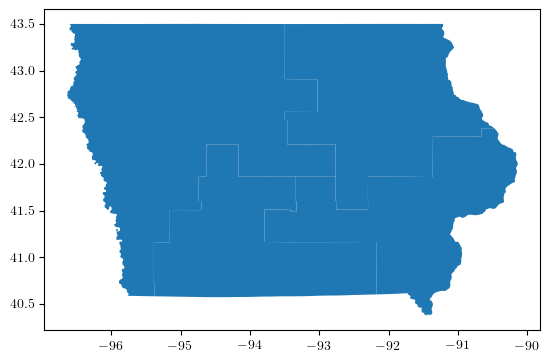

In [34]:
pIowa.plot()

In [35]:
pIowa

ID        AREA DISTRICT  MEMBERS LOCKED  NAME  POPULATION  IDEAL_VALU  \
0   2  10982.3544        1      1.0   None  None      797584    797592.0   
1   5  12963.6796        2      1.0   None  None      797589    797592.0   
2   6  10734.0546        3      1.0   None  None      797551    797592.0   
3   7  21505.5253        4      1.0   None  None      797645    797592.0   

   DEVIATION  F_DEVIATIO DISTRICT_L  \
0       -8.0   -0.000010      1|-0%   
1       -3.0   -0.000004      2|-0%   
2      -41.0   -0.000051   3|-0.01%   
3       53.0    0.000066    4|0.01%   

                                            geometry  
0  POLYGON ((-90.94938 41.07271, -90.94932 41.072...  
1  POLYGON ((-91.61083 43.50066, -91.61043 43.500...  
2  POLYGON ((-93.31749 40.58067, -93.32776 40.580...  
3  POLYGON ((-95.37392 40.58050, -95.37395 40.580...

In [38]:
def BelongsToDistrict(x):
    district = None
    for index, row in pIowa.iterrows():
        if x.centroid.within(row['geometry']):
            district = row['DISTRICT']
            break
    return district

In [39]:
gdf['district'] = gdf.apply(lambda x: BelongsToDistrict(x['geometry']), 1)

<Axes: >

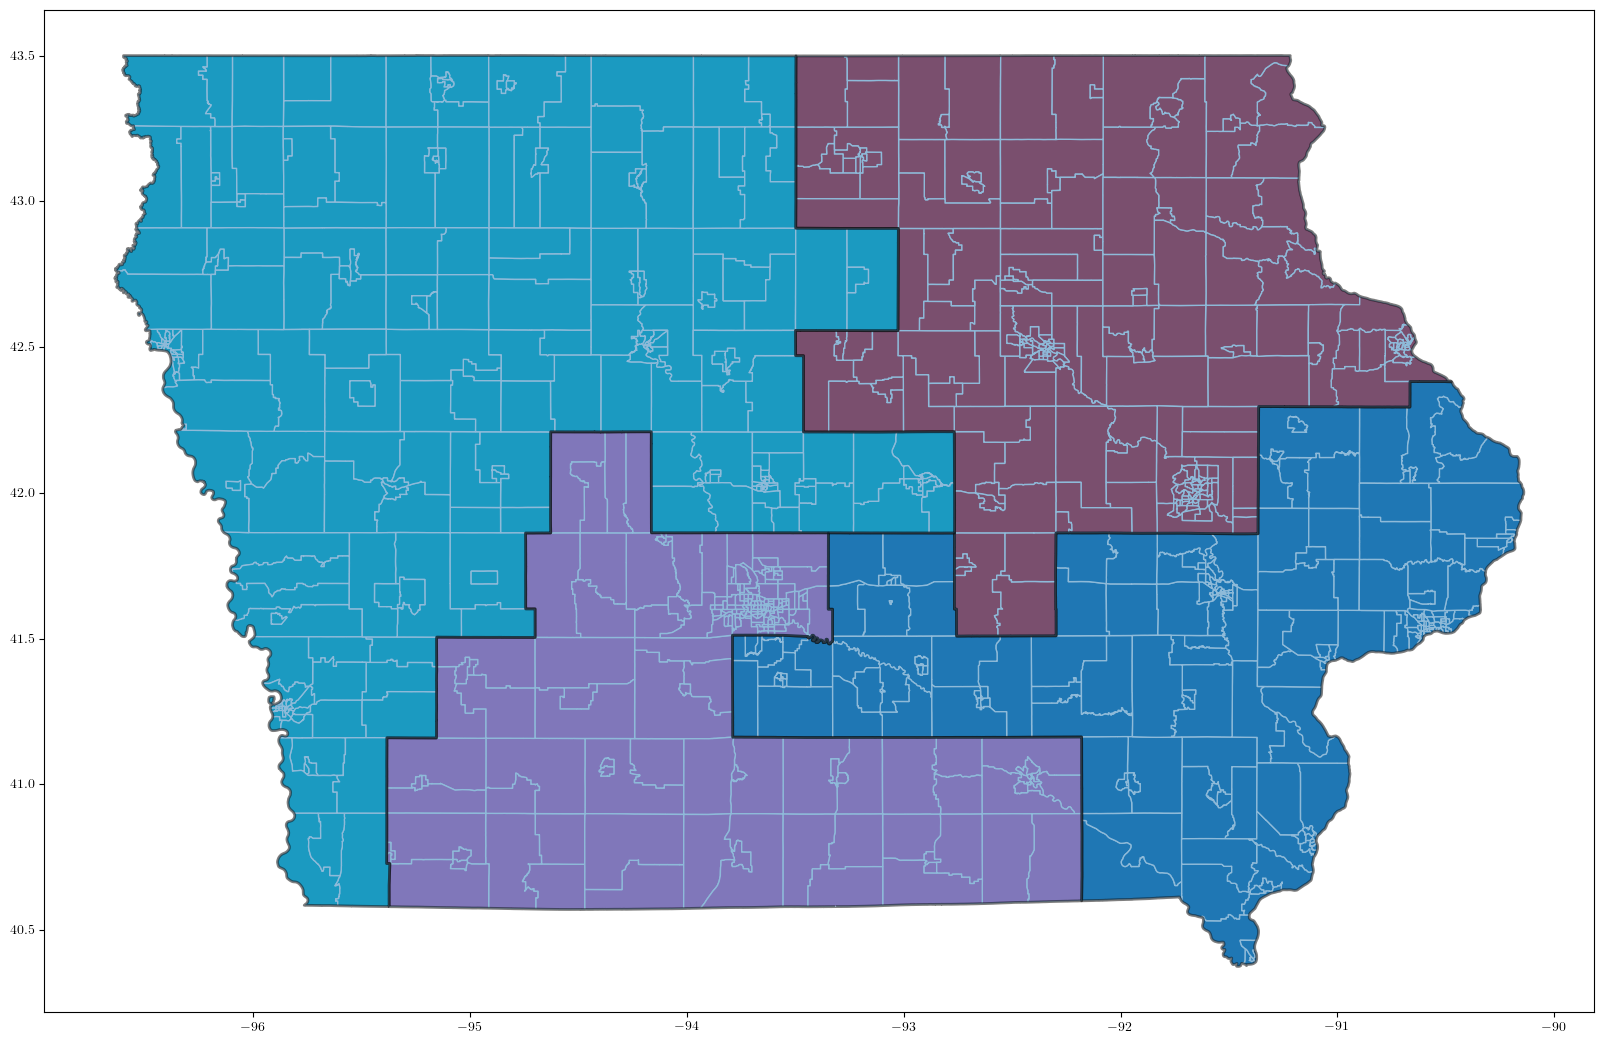

In [40]:
base = gdf.plot(figsize=(20,20),column='district', edgecolor='white')

pIowa.plot(ax=base, alpha=.5, edgecolor='black', linewidth=2)

<Axes: >

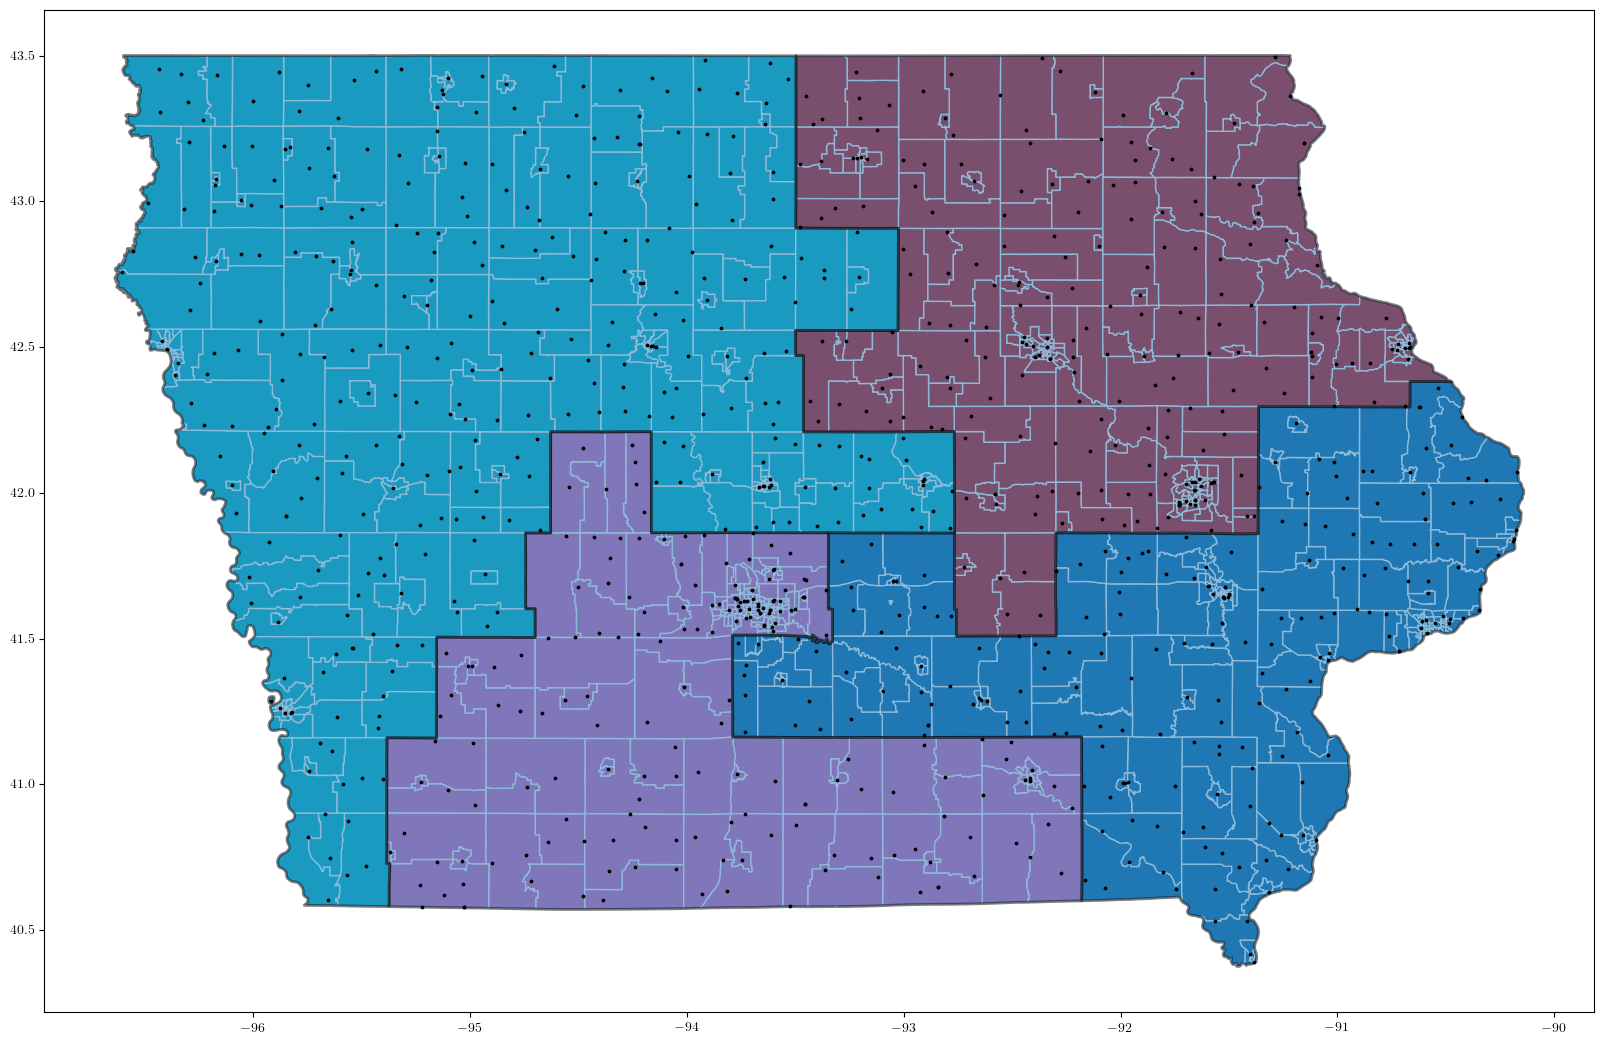

In [41]:
base = gdf.plot(figsize=(20,20),column='district', edgecolor='white')

pIowa.plot(ax=base, alpha=.5, edgecolor='black', linewidth=2)

gdf_points.plot(ax=base, color='black', markersize=3)

In [56]:
def calculate_polsby_popper_score(geometry):
    """
    Calculate Polsby-Popper compactness score for a district.
    
    Parameters:
    - geometry: Polygon or MultiPolygon geometry of the district.
    
    Returns:
    - Polsby-Popper compactness score.
    """
    area = geometry.area
    perimeter = geometry.length
    if perimeter == 0:
        return 0  # Avoid division by zero
    return (4 * math.pi * area) / perimeter**2

In [57]:
pIowa['polsby_popper_score'] = pIowa.apply(lambda x: calculate_polsby_popper_score(x['geometry']), 1)
pIowa[['DISTRICT', 'polsby_popper_score']]

DISTRICT  polsby_popper_score
0        1             0.270417
1        2             0.389781
2        3             0.322077
3        4             0.260782

In [58]:
og_minimum_compactness = pIowa['polsby_popper_score'].min()

In [59]:
pIowa

ID        AREA DISTRICT  MEMBERS LOCKED  NAME  POPULATION  IDEAL_VALU  \
0   2  10982.3544        1      1.0   None  None      797584    797592.0   
1   5  12963.6796        2      1.0   None  None      797589    797592.0   
2   6  10734.0546        3      1.0   None  None      797551    797592.0   
3   7  21505.5253        4      1.0   None  None      797645    797592.0   

   DEVIATION  F_DEVIATIO DISTRICT_L  \
0       -8.0   -0.000010      1|-0%   
1       -3.0   -0.000004      2|-0%   
2      -41.0   -0.000051   3|-0.01%   
3       53.0    0.000066    4|0.01%   

                                            geometry  polsby_popper_score  
0  POLYGON ((-90.94938 41.07271, -90.94932 41.072...             0.270417  
1  POLYGON ((-91.61083 43.50066, -91.61043 43.500...             0.389781  
2  POLYGON ((-93.31749 40.58067, -93.32776 40.580...             0.322077  
3  POLYGON ((-95.37392 40.58050, -95.37395 40.580...             0.260782

In [518]:
#pd.DataFrame(pIowa['polsby_popper_score']).boxplot(vert=False, rot=45, figsize=(10,6))

In [63]:
def create_proximity_graph(gdf_points, delta):
    # Project the GeoDataFrame to a UTM CRS that uses meters for distance calculation
    gdf_projected = gdf_points.to_crs(epsg=32615)  # Using UTM zone 15N for Iowa
    
    # Create a NetworkX graph
    G = nx.Graph()
    
    # Iterate over original points but use projected points for distance calculations
    for idx1, row1 in gdf_points.iterrows():
        G.add_node(idx1, pos=(row1.geometry.x, row1.geometry.y))  # Use original data for node positions
        
        # Iterate again for comparing distances
        for idx2, row2 in gdf_points.iterrows():
            if idx1 != idx2:
                # Get projected geometries for distance calculation
                proj_geom1 = gdf_projected.at[idx1, 'geometry']
                proj_geom2 = gdf_projected.at[idx2, 'geometry']
                # Calculate the distance using projected coordinates
                distance = proj_geom1.distance(proj_geom2)
                if distance <= delta:
                    G.add_edge(idx1, idx2)
    
    return G

In [66]:
# Assuming 'gdf_points' is your original GeoDataFrame
# Identify the appropriate UTM zone based on the data or use a generic metric CRS like EPSG:3857 (Web Mercator)
gdf_projected = gdf_points.to_crs(epsg=32615) # Using UTM zone 15N for Iowa

# Extract the coordinates in meters
coords = np.array([(point.x, point.y) for point in gdf_projected.geometry])

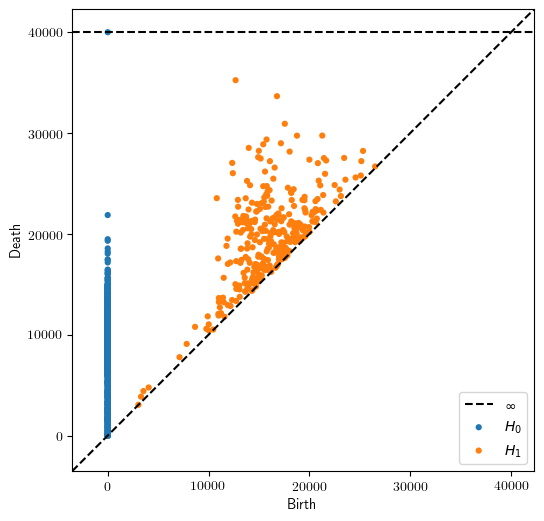

In [67]:
# Compute persistence diagrams
diagrams = ripser(coords)['dgms']
#plot_diagrams(diagrams, show=True)
# Create a larger plot
fig, ax = plt.subplots(figsize=(10, 6))  # You can adjust the size as needed
plot_diagrams(diagrams, show=True, ax=ax)
plt.show()

In [68]:
#coords = np.array([(point.x, point.y) for point in gdf_points.geometry])
result = ripser(coords, maxdim=2)
diagrams = result['dgms']

p = 100
# Calculate persistence values and determine a threshold
persistence_values = [death - birth for dim in diagrams for birth, death in dim if death != np.inf]
quantile_threshold = np.percentile(persistence_values, p)  # 90th percentile

print(f"Suggested threshold based on {p}th percentile: {quantile_threshold}")

Suggested threshold based on 100th percentile: 22556.3671875


In [69]:
# Analyzing the diagrams using the threshold
for dim, diagram in enumerate(diagrams):
    print(f"Dimension {dim}:")
    for birth, death in diagram:
        if (death - birth) > quantile_threshold:
            print(f"Significant feature from {birth} to {death}")

Dimension 0:
Significant feature from 0.0 to inf
Dimension 1:
Dimension 2:


In [70]:
quantile_threshold

22556.3671875

In [71]:
# Function to convert meters to miles
def meters_to_miles(meters):
    return meters / 1609.34

In [72]:

distance_in_miles = meters_to_miles(quantile_threshold)

print(f"Significant distance: {distance_in_miles:.2f} miles")

Significant distance: 14.02 miles


In [73]:
G = create_proximity_graph(gdf_points, quantile_threshold)

In [528]:
gdf

STATEFP COUNTYFP TRACTCE        GEOID  NAME           NAMELSAD  MTFCC  \
0        19      055  950300  19055950300  9503  Census Tract 9503  G5020   
1        19      055  950400  19055950400  9504  Census Tract 9504  G5020   
2        19      055  950200  19055950200  9502  Census Tract 9502  G5020   
3        19      055  950100  19055950100  9501  Census Tract 9501  G5020   
4        19      169  001200  19169001200    12    Census Tract 12  G5020   
..      ...      ...     ...          ...   ...                ...    ...   
891      19      099  040600  19099040600   406   Census Tract 406  G5020   
892      19      099  040200  19099040200   402   Census Tract 402  G5020   
893      19      195  690300  19195690300  6903  Census Tract 6903  G5020   
894      19      195  690200  19195690200  6902  Census Tract 6902  G5020   
895      19      195  690100  19195690100  6901  Census Tract 6901  G5020   

    FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
0          S   27142261    64413  +42.4880514  -091.4603285   
1          S  735669629  2021640  +42.3756176  -091.3534927   
2          S  355629133   914273  +42.5591162  -091.4957852   
3          S  377752377   185049  +42.5502199  -091.2470106   
4          S     292480        0  +42.0139985  -093.6479807   
..       ...        ...      ...          ...           ...   
891        S    2649238        0  +41.6914425  -093.0669455   
892        S  402378127   678459  +41.7742733  -093.2253436   
893        S  344375806   122600  +43.3349828  -093.1461544   
894        S  511970670  4438965  +43.3788589  -093.3840078   
895        S  179968456   147562  +43.4535564  -093.1520135   

                                              geometry   tract_id_x  \
0    POLYGON ((-91.53625 42.49823, -91.53573 42.498...  19055950300   
1    POLYGON ((-91.59784 42.38613, -91.59782 42.388...  19055950400   
2    POLYGON ((-91.60906 42.55734, -91.60904 42.558...  19055950200   
3    POLYGON ((-91.37496 42.62880, -91.37484 42.629...  19055950100   
4    POLYGON ((-93.65168 42.01411, -93.65165 42.015...  19169001200   
..                                                 ...          ...   
891  POLYGON ((-93.07728 41.69191, -93.07728 41.692...  19099040600   
892  POLYGON ((-93.34850 41.68995, -93.34849 41.693...  19099040200   
893  POLYGON ((-93.27073 43.38607, -93.26936 43.386...  19195690300   
894  POLYGON ((-93.49782 43.40830, -93.49776 43.408...  19195690200   
895  POLYGON ((-93.27183 43.49949, -93.26781 43.499...  19195690100   

    population district  
0         5207        2  
1         5451        2  
2         3193        2  
3         3637        2  
4          273        4  
..         ...      ...  
891       3059        1  
892       3989        1  
893       2693        2  
894       2220        2  
895       2530        2  

[896 rows x 16 columns]

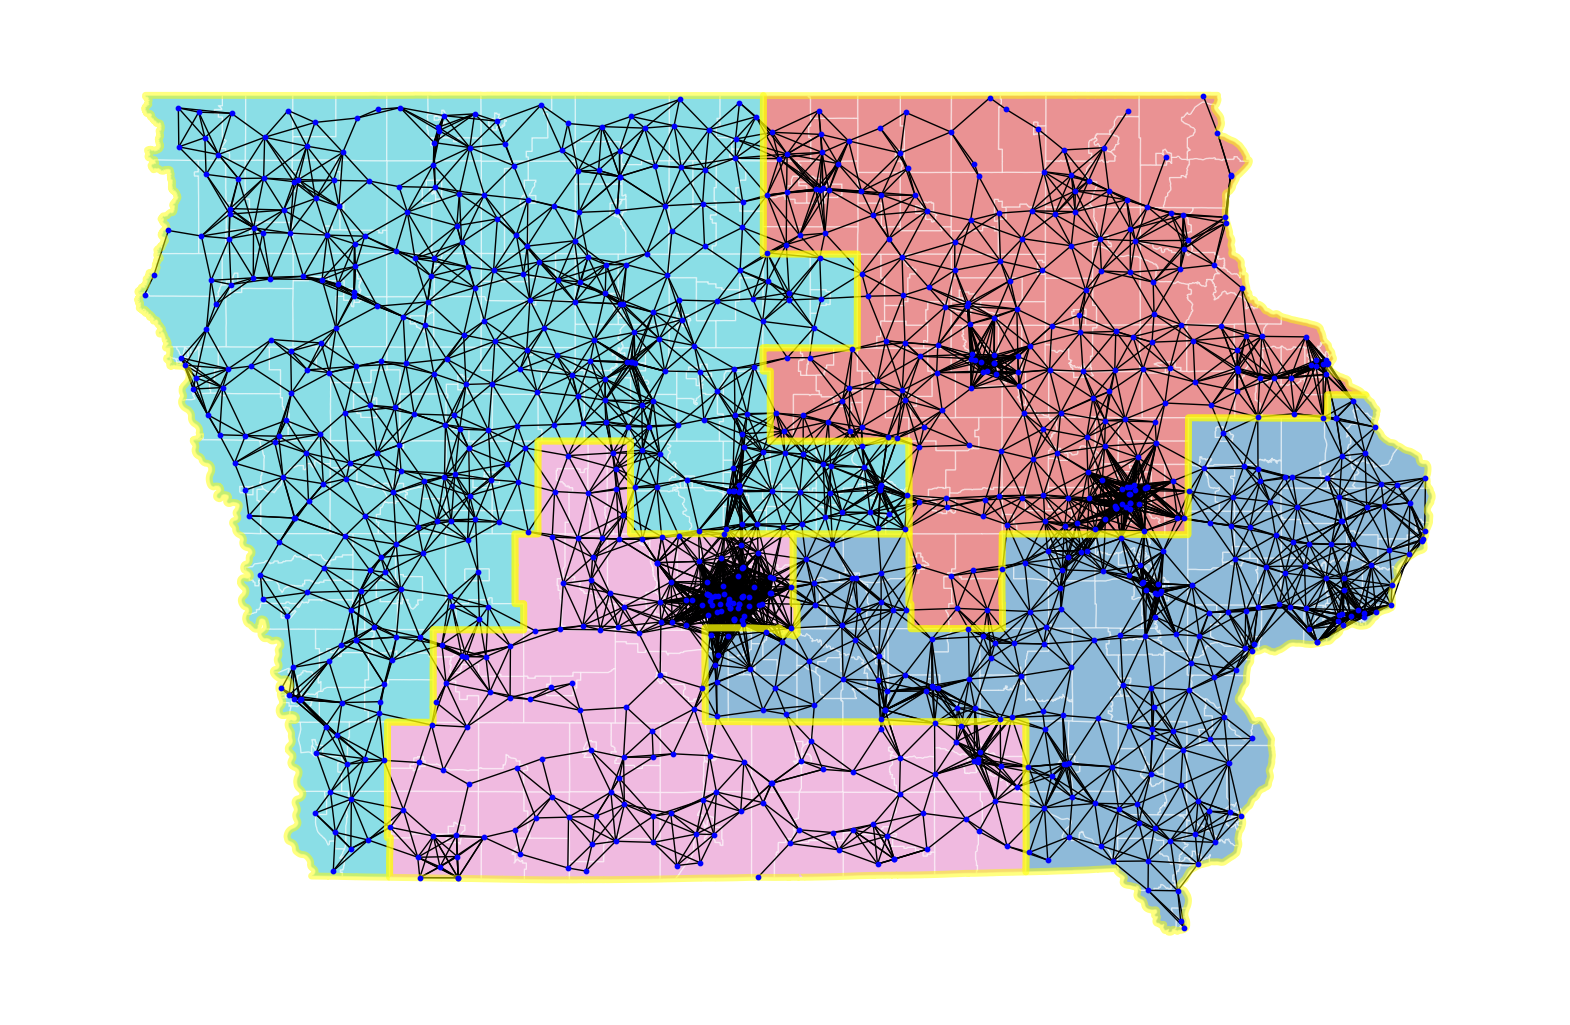

In [527]:
# Plotting the graph
base = gdf.plot(figsize=(20,20),column='district', edgecolor='white', alpha=.5)

pos = {node:(data['pos'][0], data['pos'][1]) for node, data in G.nodes(data=True)}
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='black', ax=base)
pIowa.plot(ax=base, alpha=.5, edgecolor='yellow', linewidth=5, facecolor='none')
plt.show()

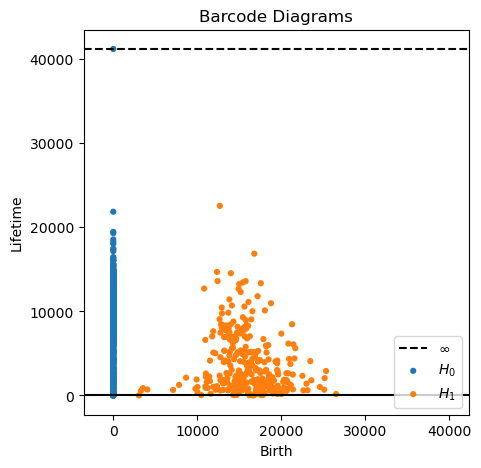

In [76]:
# Plot the barcode diagrams using Persim
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the size as needed
plot_diagrams(diagrams, show=True, ax=ax, plot_only=[0, 1], lifetime=True, title="Barcode Diagrams")


In [78]:
# Assuming 'G' is your networkx graph and 'pos' is your position dict
edges = [LineString([pos[u], pos[v]]) for u, v in G.edges()]

# Create a GeoDataFrame for edges
gdf_edges = gpd.GeoDataFrame(geometry=edges)

In [79]:
gdf_edges.shape

(5893, 1)

In [80]:
# removing edges that leave the state
def filter_edges_within_state(gdf_edges, counties):
    union_of_counties = counties.unary_union
    contained_edges = []

    for idx, edge in gdf_edges.iterrows():
        # Check if the edge is completely contained within the union of all counties
        if union_of_counties.contains(edge.geometry):
            contained_edges.append(idx)

    # Filter the GeoDataFrame to only include contained edges
    return gdf_edges.loc[contained_edges]

In [81]:
# filtered version
#gdf_edges = filter_edges_within_state(gdf_edges, counties)
#gdf_edges.shape

In [82]:
# Assuming 'pIowa' is your GeoDataFrame containing district polygons
# Create a spatial index on the district boundaries for faster queries
sindex = pIowa.sindex

# List to hold the indices of edges that are cut
cut_edges = []

# Function to check if an edge is within any district
def is_edge_within_any_district(edge, districts):
    for _, district in districts.iterrows():
        if district.geometry.contains(edge):
            return True
    return False

# Check each edge for intersection with district boundaries
for idx, edge in gdf_edges.iterrows():
    # Skip if edge is completely within any district
    if is_edge_within_any_district(edge.geometry, pIowa):
        continue
    
    # Find potential matches with district boundaries using spatial index
    possible_matches_index = list(sindex.intersection(edge.geometry.bounds))
    possible_matches = pIowa.iloc[possible_matches_index]
    
    # Check precise intersection
    for _, possible_match in possible_matches.iterrows():
        intersection = edge.geometry.intersection(possible_match.geometry)
        # Check if the intersection is a line and different from the original edge
        #if isinstance(intersection, (LineString, MultiLineString)) and not edge.geometry.equals(intersection):
        if not intersection.equals(edge.geometry):
            cut_edges.append(idx)
            break  # Exit loop after first cut to prevent double counting

cut_edges_count = len(cut_edges)

In [84]:
len(edges)

5893

- Aggregate tracts into counties: get their combined geometry as a polygon, and combined population. This data is in the geopandas table gdf and columns 'COUNTYFP', 'geometry', 'population'
- establish target_population size as total population over number of districts.
- establish an acceptable threshold for deviation in target population (start with something somewhat big, like 10%)
- Now we have our constraints for MCMC which are population of each district within +/-10 of target_population, and that any district created has to form a polygon when the counties are joined.
- pass those constrains to MCMC and start generating plans and for each acceptable plan, we are going to go through our function and loop that counts the cut edges.
- Calculate the distribution of cut_edges.
- Then compare the cut_edges from the original plan which we have already computed with respect to the new distribution to obtain the insights of how good the existing plan is with respect to the distribution.

In [86]:
'COUNTYFP', 'geometry', 'population'

('COUNTYFP', 'geometry', 'population')

# MCMC

In [88]:
# Assuming 'gdf' is your GeoDataFrame with tracts
counties = gdf.dissolve(by='COUNTYFP', aggfunc={'population': 'sum','district_x':'first'})
counties.columns = ['geometry', 'population', 'district']
counties['district'] = counties['district'].astype('int')
counties['population'] = counties['population'].astype('int')
counties

geometry  population  \
COUNTYFP                                                                  
001       POLYGON ((-94.70052 41.23027, -94.70051 41.230...        7496   
003       POLYGON ((-94.92852 40.90452, -94.92851 40.904...        3704   
005       POLYGON ((-91.23224 43.46002, -91.23319 43.457...       14061   
007       POLYGON ((-93.09747 40.74518, -93.09745 40.746...       12317   
009       POLYGON ((-95.04095 41.57081, -95.04093 41.571...        5674   
...                                                     ...         ...   
189       POLYGON ((-93.62325 43.25563, -93.62510 43.255...       10679   
191       POLYGON ((-91.61087 43.41606, -91.61089 43.415...       20070   
193       POLYGON ((-96.32492 42.22906, -96.32479 42.229...      105941   
195       POLYGON ((-93.02422 43.41365, -93.02422 43.412...        7443   
197       POLYGON ((-93.49873 42.81934, -93.49871 42.817...       12943   

          district  
COUNTYFP            
001              3  
003              3  
005              2  
007              3  
009              4  
...            ...  
189              4  
191              2  
193              4  
195              2  
197              4  

[99 rows x 3 columns]

<Axes: >

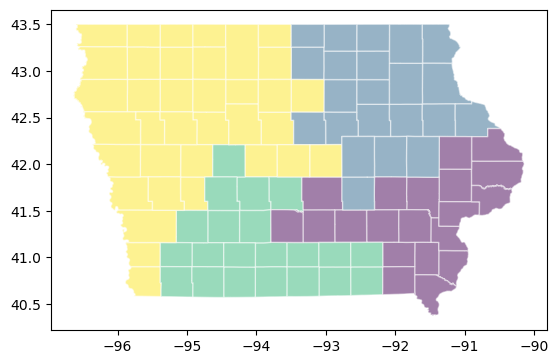

In [89]:
counties.plot(column='district', edgecolor='white', alpha=0.5)

In [90]:
total_population = counties['population'].sum()
number_of_districts = 4  # As an example
target_population = total_population / number_of_districts
deviation_threshold = 0.05  # 10%
min_population = target_population * (1 - deviation_threshold)
max_population = target_population * (1 + deviation_threshold)


In [91]:
min_population, max_population

(757712.6375, 837471.8625)

In [92]:
# Random initial assignment of counties to districts
#counties['district'] = [random.randint(1, number_of_districts) for _ in range(len(counties))]

# Function to create districts from counties
def create_districts(counties_gdf):
    districts = counties_gdf.dissolve(by='district', aggfunc={'population': 'sum'})
    return districts


In [93]:
def calculate_polsby_popper_score(geometry):
    area = geometry.area
    perimeter = geometry.length
    if perimeter == 0:
        return 0  # Avoid division by zero
    return (4 * math.pi * area) / (perimeter**2)

def check_compactness(gdf):

    compactness_scores = []

    for did, group in gdf.groupby('district'):
        district_geometry = group.unary_union
        compactness_score = calculate_polsby_popper_score(district_geometry)
        compactness_scores.append({'district': did, 'compactness': compactness_score})

    return pd.DataFrame(compactness_scores)

In [94]:
def propose_new_districts(counties_gdf):
    # Sample a random county
    random_county = counties_gdf.sample(1)
    current_district = random_county['district'].iloc[0]
    new_district = random.choice([d for d in range(1, number_of_districts + 1) if d != current_district])

    # Convert index to scalar
    county_index = random_county.index.item()  # Convert the Index object to a scalar
    
    # Propose moving it to a new district
    counties_gdf.at[county_index, 'district'] = new_district
    
    # Return the updated counties dataframe and details of the moved county
    return counties_gdf #, county_index #, current_district, new_district


In [95]:
def accept_proposal(proposed_districts, minimum_compactness, compactness_threshold=0.9):
    # Check population constraints
    if any((proposed_districts['population'] < min_population) | (proposed_districts['population'] > max_population)):
        return False

    # Check for compactness of each district and compare with original plan's minimum compactness
    min_compactness = min(calculate_polsby_popper_score(geom) for geom in proposed_districts['geometry'])
    if min_compactness < minimum_compactness * compactness_threshold:
        return False

    # Check for contiguity and validity of each district's geometry
    for geom in proposed_districts['geometry']:
        if not isinstance(geom, Polygon) or not geom.is_valid or not geom.is_simple:
            return False

    return True

In [96]:
def is_edge_within_any_district(edge, districts):
    """Check if an edge is completely contained within any district."""
    for _, district in districts.iterrows():
        if district.geometry.contains(edge):
            return True
    return False

In [99]:
def calculate_cut_edges(districts, gdf_edges):
    """Calculate the number of edges cut by district boundaries."""
    # Initialize edge cutting counter
    cut_edges = []

    # Assuming a spatial index exists for the districts
    sindex = districts.sindex

    # Check each edge for intersection with district boundaries
    for idx, edge in gdf_edges.iterrows():
        # Skip if edge is completely within any district
        if is_edge_within_any_district(edge.geometry, districts):
            continue
        
        # Find potential matches with district boundaries using spatial index
        possible_matches_index = list(sindex.intersection(edge.geometry.bounds))
        possible_matches = districts.iloc[possible_matches_index]
        
        # Check precise intersection
        for _, possible_match in possible_matches.iterrows():
            intersection = edge.geometry.intersection(possible_match.geometry)
            # Check if the intersection is a line and different from the original edge
            if intersection.type == 'LineString' and not edge.geometry.equals(intersection):
                cut_edges.append(idx)
                break  # Exit loop after first cut to prevent double counting

    return len(cut_edges)

In [100]:
def map_county_to_edges(gdf_edges, counties):
    #union_of_counties = counties.unary_union
    
    county_edge_map = defaultdict(list)
    for idx, edge in gdf_edges.iterrows():
        #intersected_with_union = edge.geometry.intersection(union_of_counties)
        
        # Check if the edge leaves and re-enters the state
        #if isinstance(intersected_with_union, MultiLineString):
        #    continue  # Skip this edge as it exits and re-enters the region
        
        # Iterate through each county and check for intersections
        for county_id, county in counties.iterrows():
            if edge.geometry.intersects(county.geometry):
                intersection = edge.geometry.intersection(county.geometry)
                # Check if the intersection is identical to the edge geometry
                if not intersection.equals(edge.geometry):
                    # If not identical, it means the edge crosses the boundary
                    county_edge_map[county_id].append(idx)
    return county_edge_map

In [101]:
county_edge_map = map_county_to_edges(gdf_edges, counties)

In [102]:
# Gather all edge indices from all counties into a single list
all_crossover_edges = []
for edges_list in county_edge_map.values():
    all_crossover_edges.extend(edges_list)

# Convert the list to a set to remove duplicates
unique_crossover_edges = set(all_crossover_edges)

# If you need it back as a list
unique_crossover_edges_list = list(unique_crossover_edges)

# Now unique_edges_list contains all unique indices


In [103]:
len(unique_crossover_edges_list)

2106

In [104]:
#gdf_edges.loc[unique_crossover_edges_list]

In [617]:
og_plan_cut_edges_count = calculate_cut_edges(create_districts(counties), gdf_edges.loc[unique_crossover_edges_list])

In [105]:
def generate_initial_districts(counties_gdf, number_of_districts):
    while True:
        # Randomly assign districts
        counties_gdf['district'] = [random.randint(1, number_of_districts) for _ in range(len(counties_gdf))]
        proposed_districts = create_districts(counties_gdf)
        
        # Check if this random configuration is admissible
        if accept_proposal(proposed_districts=proposed_districts, 
                           minimum_compactness=og_minimum_compactness, 
                           compactness_threshold=0.95):
            break
    return counties_gdf

In [106]:
counties_initializer = counties.copy()

In [107]:
#import geopandas as gpd
#import numpy as np
#from shapely.geometry import MultiPolygon
#from shapely.ops import unary_union

In [108]:
counties

geometry  population  \
COUNTYFP                                                                  
001       POLYGON ((-94.70052 41.23027, -94.70051 41.230...        7496   
003       POLYGON ((-94.92852 40.90452, -94.92851 40.904...        3704   
005       POLYGON ((-91.23224 43.46002, -91.23319 43.457...       14061   
007       POLYGON ((-93.09747 40.74518, -93.09745 40.746...       12317   
009       POLYGON ((-95.04095 41.57081, -95.04093 41.571...        5674   
...                                                     ...         ...   
189       POLYGON ((-93.62325 43.25563, -93.62510 43.255...       10679   
191       POLYGON ((-91.61087 43.41606, -91.61089 43.415...       20070   
193       POLYGON ((-96.32492 42.22906, -96.32479 42.229...      105941   
195       POLYGON ((-93.02422 43.41365, -93.02422 43.412...        7443   
197       POLYGON ((-93.49873 42.81934, -93.49871 42.817...       12943   

          district  
COUNTYFP            
001              3  
003              3  
005              2  
007              3  
009              4  
...            ...  
189              4  
191              2  
193              4  
195              2  
197              4  

[99 rows x 3 columns]

In [109]:
from sklearn.cluster import KMeans

In [234]:
from shapely.geometry import Polygon, MultiPolygon

district
0     465563
1     559654
2    1140760
3    1024392
Name: population, dtype: int64
District populations within tolerance: False


<Axes: >

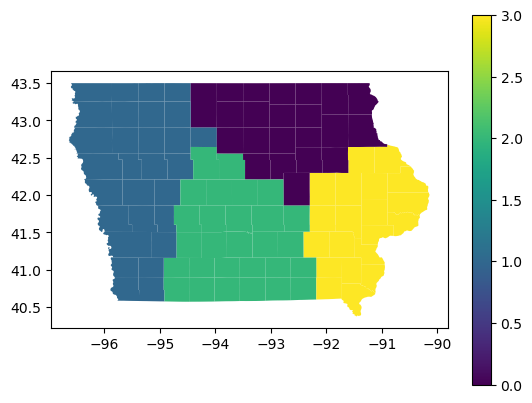

In [329]:
# Step 1: Create a copy and change the projection
gdf_proj = counties_initializer.copy().to_crs(epsg=32615)  # Using UTM zone 15N for Iowa

# Step 2: Calculate centroids in the projected CRS
gdf_proj['centroid'] = gdf_proj.centroid

# Step 3: Prepare data for clustering
X = np.array(list(zip(gdf_proj['centroid'].x, gdf_proj['centroid'].y)))
weights = gdf_proj['population'].values

# Step 4: Run Hierarchical Clustering
clustering = KMeans(n_clusters=4)
clustering.fit(X, sample_weight=weights)

# Step 5: Assign districts
gdf_proj['district'] = agg_clustering.labels_

tolerance = target_population * 0.05

# Calculate population of each district
district_populations = gdf_proj.groupby('district')['population'].sum()

# Print district populations and check if they are within tolerance
print(district_populations)
within_tolerance = all(abs(p - target_population) <= tolerance for p in district_populations)
print(f"District populations within tolerance: {within_tolerance}")

# Step 7: Validation and Visualization
# Visualize the result
#gdf_proj.plot(column='district', legend=True)

# Optionally, if you need the results in the original CRS
counties_initializer['district'] = gdf_proj['district']

counties_initializer.plot(column='district', legend=True)

In [513]:
create_districts(counties_initializer)

geometry  population
district                                                               
0         POLYGON ((-93.10160 40.58387, -93.10161 40.583...     1169098
1         POLYGON ((-92.76605 42.00795, -92.76607 42.008...      465563
2         POLYGON ((-95.38470 40.88455, -95.38470 40.882...      531316
3         POLYGON ((-91.38196 40.38763, -91.38420 40.386...     1024392

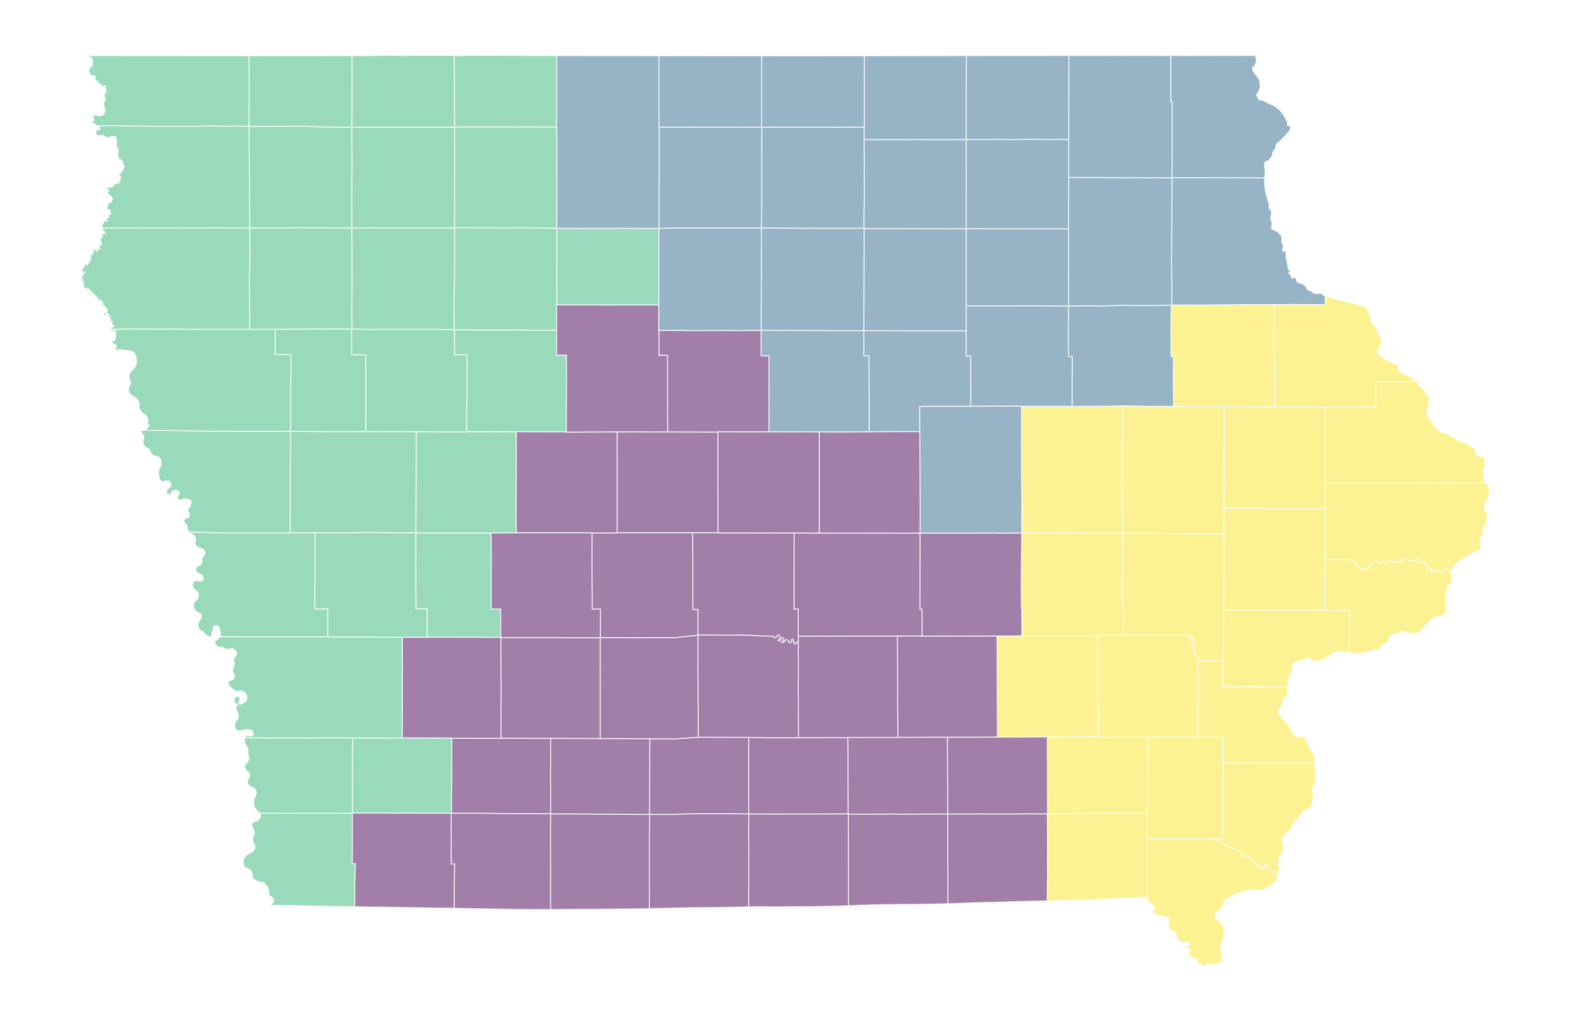

In [512]:
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the main GeoDataFrame
base = counties_initializer.plot(ax=ax, column='district', edgecolor='white', alpha=0.5)

# Hide the x and y axis labels
ax.set_xticks([])  # Hide x-axis ticks
ax.set_yticks([])  # Hide y-axis ticks

# Optionally, if you want to hide the axis lines as well:
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Remove the frame of the plot
ax.set_frame_on(False)


plt.show()

In [308]:
# Function to calculate district populations and compactness
def calculate_district_populations(gdf):
    return gdf.groupby('district')['population'].sum()


def accept_interim_proposal(proposed_districts, minimum_interim_compactness):
    # Check for compactness of each district and compare with original plan's minimum compactness
    min_compactness = min(calculate_polsby_popper_score(geom) for geom in proposed_districts['geometry'])
    if min_compactness < minimum_interim_compactness:
        return False

    # Check for contiguity and validity of each district's geometry
    for geom in proposed_districts['geometry']:
        if not isinstance(geom, Polygon) or not geom.is_valid or not geom.is_simple:
            return False

    return True

In [309]:
#counties_initializer.groupby('district')['geometry'].apply(lambda x: unary_union(x))

In [330]:
district_populations[district_populations > max_population].index.tolist()

[2, 3]

In [ ]:
calculate_cut_edges(create_districts(counties_initialzer), gdf_edges.loc[unique_crossover_edges_list])

District populations within tolerance: True
district
0    822634
1    789403
2    791865
3    786467
Name: population, dtype: int64


<Axes: >

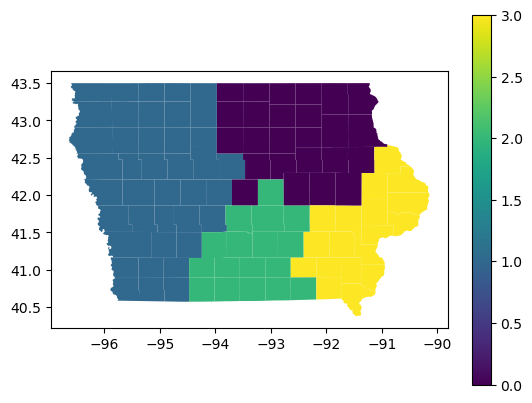

In [333]:
# Step 7: Adjust regions to meet population constraints
iterations = 0
max_iterations = 1000

while iterations < max_iterations:
    district_populations = counties_initializer.groupby('district')['population'].sum()
    min_int_compact = counties_initializer.groupby('district')['geometry'].apply(lambda x: calculate_polsby_popper_score(unary_union(x))
                                                                                ).min()

    # Identify districts below and above the population threshold
    underpopulated_districts = district_populations[district_populations < min_population].index.tolist()
    overpopulated_districts = district_populations[district_populations > max_population].index.tolist()

    if (not underpopulated_districts and not overpopulated_districts) and (min_int_compact > og_minimum_compactness * 0.95):
        break

    if underpopulated_districts:
        # Select an underpopulated district
        under_district = random.choice(underpopulated_districts) #underpopulated_districts[0]
        
        # Sample a county from any overpopulated district and try to move it to the underpopulated district
        counties_in_over_districts = counties_initializer[counties_initializer['district'].isin(overpopulated_districts)]
        county_to_move = counties_in_over_districts.sample(1).index[0]
    
        # Move the county and check if the new assignment is acceptable
        original_district = counties_initializer.at[county_to_move, 'district']
        counties_initializer.at[county_to_move, 'district'] = under_district
    
        temp_districts = counties_initializer.groupby('district')['geometry'].apply(lambda x: unary_union(x)).reset_index()
    
        if accept_interim_proposal(temp_districts, minimum_interim_compactness=min_int_compact):
            #print('yes')
            continue
        else:
            # Revert the move if not acceptable
            counties_initializer.at[county_to_move, 'district'] = original_district
    else:
        # No underpopulated districts; try to balance within overpopulated districts
        for over_district in overpopulated_districts:
            counties_in_over_district = counties_initializer[counties_initializer['district'] == over_district]
            county_to_move = counties_in_over_district.sample(1).index[0]

            potential_underpopulated_districts = district_populations[district_populations < max_population].index.tolist()
            for potential_under_district in potential_underpopulated_districts:
                if district_populations[potential_under_district] + counties_initializer.at[county_to_move, 'population'] <= max_population:
                    original_district = counties_initializer.at[county_to_move, 'district']
                    counties_initializer.at[county_to_move, 'district'] = potential_under_district

                    temp_districts = counties_initializer.groupby('district')['geometry'].apply(lambda x: unary_union(x)).reset_index()

                    if accept_interim_proposal(temp_districts, minimum_interim_compactness=min_int_compact):
                        break
                    else:
                        # Revert the move if not acceptable
                        counties_initializer.at[county_to_move, 'district'] = original_district
                else:
                    continue

    iterations += 1

# Check final population balance and compactness
final_populations = counties_initializer.groupby('district')['population'].sum()
within_tolerance = all(abs(p - target_population) <= tolerance for p in final_populations)
print(f"District populations within tolerance: {within_tolerance}")
print(final_populations)

# Visualize the result
counties_initializer.plot(column='district', legend=True)


In [334]:
min_population, target_population, max_population

(757712.6375, 797592.25, 837471.8625)

In [335]:
calculate_district_populations(counties_initializer)

district
0    822634
1    789403
2    791865
3    786467
Name: population, dtype: int64

<Axes: >

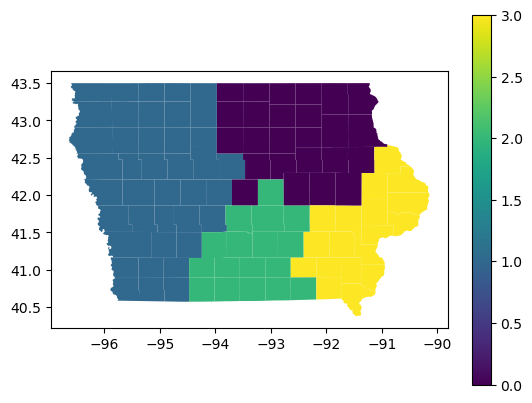

In [336]:
counties_initializer.plot(column='district', legend=True)

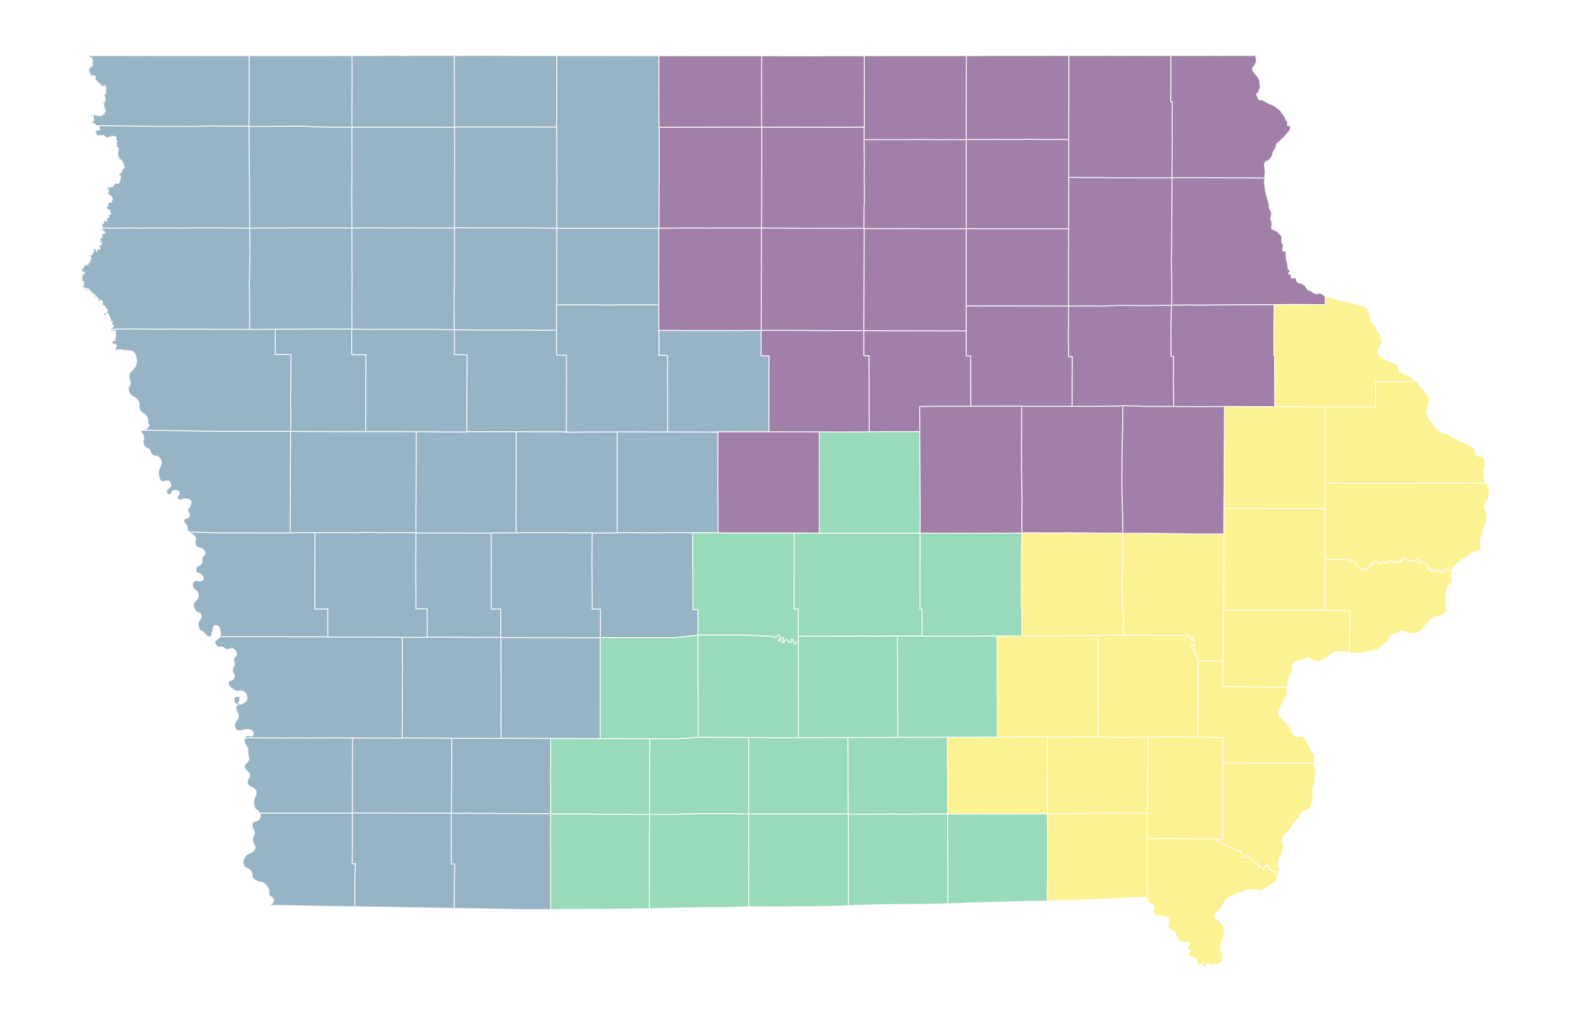

In [507]:
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the main GeoDataFrame
base = counties_initializer.plot(ax=ax, column='district', edgecolor='white', alpha=0.5)

# Hide the x and y axis labels
ax.set_xticks([])  # Hide x-axis ticks
ax.set_yticks([])  # Hide y-axis ticks

# Optionally, if you want to hide the axis lines as well:
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Remove the frame of the plot
ax.set_frame_on(False)

# Set the outer background color of the axes
#fig.patch.set_facecolor('gray')  # This changes the figure background color

plt.show()

In [504]:
create_districts(counties_initializer)

geometry  population
district                                                               
0         POLYGON ((-92.76607 42.00863, -92.76607 42.008...      822634
1         POLYGON ((-94.47126 40.71796, -94.47126 40.717...      789403
2         POLYGON ((-94.47140 40.62415, -94.47141 40.624...      791865
3         POLYGON ((-92.17938 40.62444, -92.17916 40.634...      786467

In [ ]:
calculate_cut_edges(create_districts(counties_initializer), gdf_edges.loc[unique_crossover_edges_list])

In [323]:
max_population

837471.8625

In [324]:
iterations

1000

In [337]:
def mcmc_simulation(counties_gdf, gdf_edges, burn_in_rate=.15, iterations=10000, initial_districts=None):
    burn_in = int(iterations * burn_in_rate)
    #current_districts = create_districts(counties_gdf)
    current_districts = initial_districts if initial_districts is not None else create_districts(counties_gdf)
    history = []
    min_cut_edges = float('inf')
    best_configuration = None
    #best_cut_edges_list = []

    for i in tqdm(range(iterations), desc="Running MCMC Simulation"):
        proposed_counties = propose_new_districts(counties_gdf.copy())
        proposed_districts = create_districts(proposed_counties)

        if accept_proposal(proposed_districts=proposed_districts, 
                           minimum_compactness=og_minimum_compactness, 
                           compactness_threshold=0.95):
            counties_gdf = proposed_counties
            current_districts = proposed_districts

            
            # Only record history and check for best configuration after burn-in
            if i >= burn_in:
                cut_edges_count = calculate_cut_edges(current_districts, 
                                                      gdf_edges.loc[unique_crossover_edges_list])
                history.append(cut_edges_count)
                if cut_edges_count < min_cut_edges:
                    min_cut_edges = cut_edges_count
                    best_configuration = copy.deepcopy(current_districts)
                    best_configuration.reset_index(inplace=True)
                    #best_cut_edges_list = cut_edges_list
        else:
            if i >= burn_in:
                history.append(None)

    return history, min_cut_edges, best_configuration, current_districts

In [338]:
# Run MCMC
history, min_cuts, best_config, current_districts = mcmc_simulation(counties_initializer, 
                                                                    gdf_edges.loc[unique_crossover_edges_list], 
                                                                    burn_in_rate=.2, iterations=50000)

Running MCMC Simulation: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [3:46:22<00:00,  3.68it/s]


In [3110]:
#current_districts = create_districts(counties_current)

In [644]:
# Run MCMC
history_new, min_cuts_new, best_config_new, current_districts = mcmc_simulation(counties, 
                                                                                gdf_edges.loc[unique_crossover_edges_list],
                                                                                burn_in_rate=0, iterations=100000, 
                                                                                initial_districts=current_districts)

history = history + history_new
if min_cuts_new < min_cuts:
    min_cuts = min_cuts_new
    best_config = best_config_new

Running MCMC Simulation: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [10:11:47<00:00,  2.72it/s]


Minimum cut edges encountered: 315


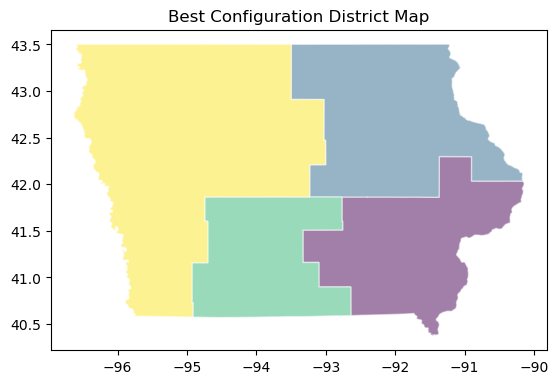

In [646]:
print(f"Minimum cut edges encountered: {min_cuts}")
#best_config.reset_index(inplace=True)

# Now plot using 'district' as the color coding column
best_config.plot(column='district', edgecolor='white', alpha=0.5)
plt.title("Best Configuration District Map")
plt.show()

In [647]:
len(history)

990000

In [648]:
# Filter out None values from the history for a histogram of valid counts
valid_counts = [count for count in history if count is not None]
print(valid_counts[-50:])

[420, 427, 431, 443, 431, 416, 406, 426, 454, 434, 438, 421, 393, 391, 414, 420, 415, 412, 426, 420, 405, 391, 420, 407, 409, 410, 423, 393, 389, 419, 418, 415, 421, 415, 425, 395, 383, 401, 431, 413, 386, 381, 374, 381, 386, 420, 399, 422, 422, 426]


In [649]:
len(valid_counts)

45344

In [650]:
# Calculate mean and standard deviation of the distribution
mean_counts = np.mean(valid_counts)
std_counts = np.std(valid_counts)

# Probability density of the observed plan
probability_density = norm.pdf(og_plan_cut_edges_count, mean_counts, std_counts)

print(f"The likelihood of choosing the observed plan at random is: {probability_density:.6f}")

The likelihood of choosing the observed plan at random is: 0.001842


In [768]:
# Function to plot the histogram and fitted normal distribution
def plot_distribution(ax, valid_counts, og_plan_cut_edges_count, min_cuts, iteration):
    # Fit a normal distribution to the data
    mu, std = norm.fit(valid_counts)
    
    # Calculate the probability of choosing a plan worse than the original plan
    p_value = 1 - norm.cdf(og_plan_cut_edges_count, mu, std)

    # Plot the histogram
    ax.hist(valid_counts, bins=50, density=True, color='pink', alpha=0.7, label='Histogram')

    # Plot the PDF of the fitted normal distribution
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    #ax.plot(x, p, 'k', linewidth=2, label=f'Fitted Normal Distribution\n(mean={mu:.2f}, std={std:.2f})')

    # Plot the original, minimum and average plan
    #ax.axvline(x=og_plan_cut_edges_count, color='green', linestyle='-', linewidth=2, 
    #           label=f'Original Plan ({og_plan_cut_edges_count} edges)')
    #ax.axvline(x=min_cuts, color='red', linestyle='dashed', linewidth=2, 
    #           label=f'Observed Minimum ({min_cuts} edges)')
    #ax.axvline(x=np.mean(valid_counts), color='black', linestyle='dashed', linewidth=1, 
    #           label=f'Average Plan ({round(np.mean(valid_counts), 2)} edges)')

    # Add labels, title, legend, and grid
    ax.set_title(f'After {iteration} Observations')
    ax.set_xlabel('Number of Cut Edges')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True)

In [769]:
print(valid_counts[:50])

[658, 649, 671, 648, 644, 636, 640, 651, 651, 626, 636, 661, 650, 631, 621, 600, 607, 604, 607, 607, 602, 614, 639, 665, 675, 650, 642, 630, 605, 608, 608, 633, 630, 654, 630, 633, 651, 656, 653, 653, 643, 657, 650, 676, 679, 653, 655, 652, 628, 635]


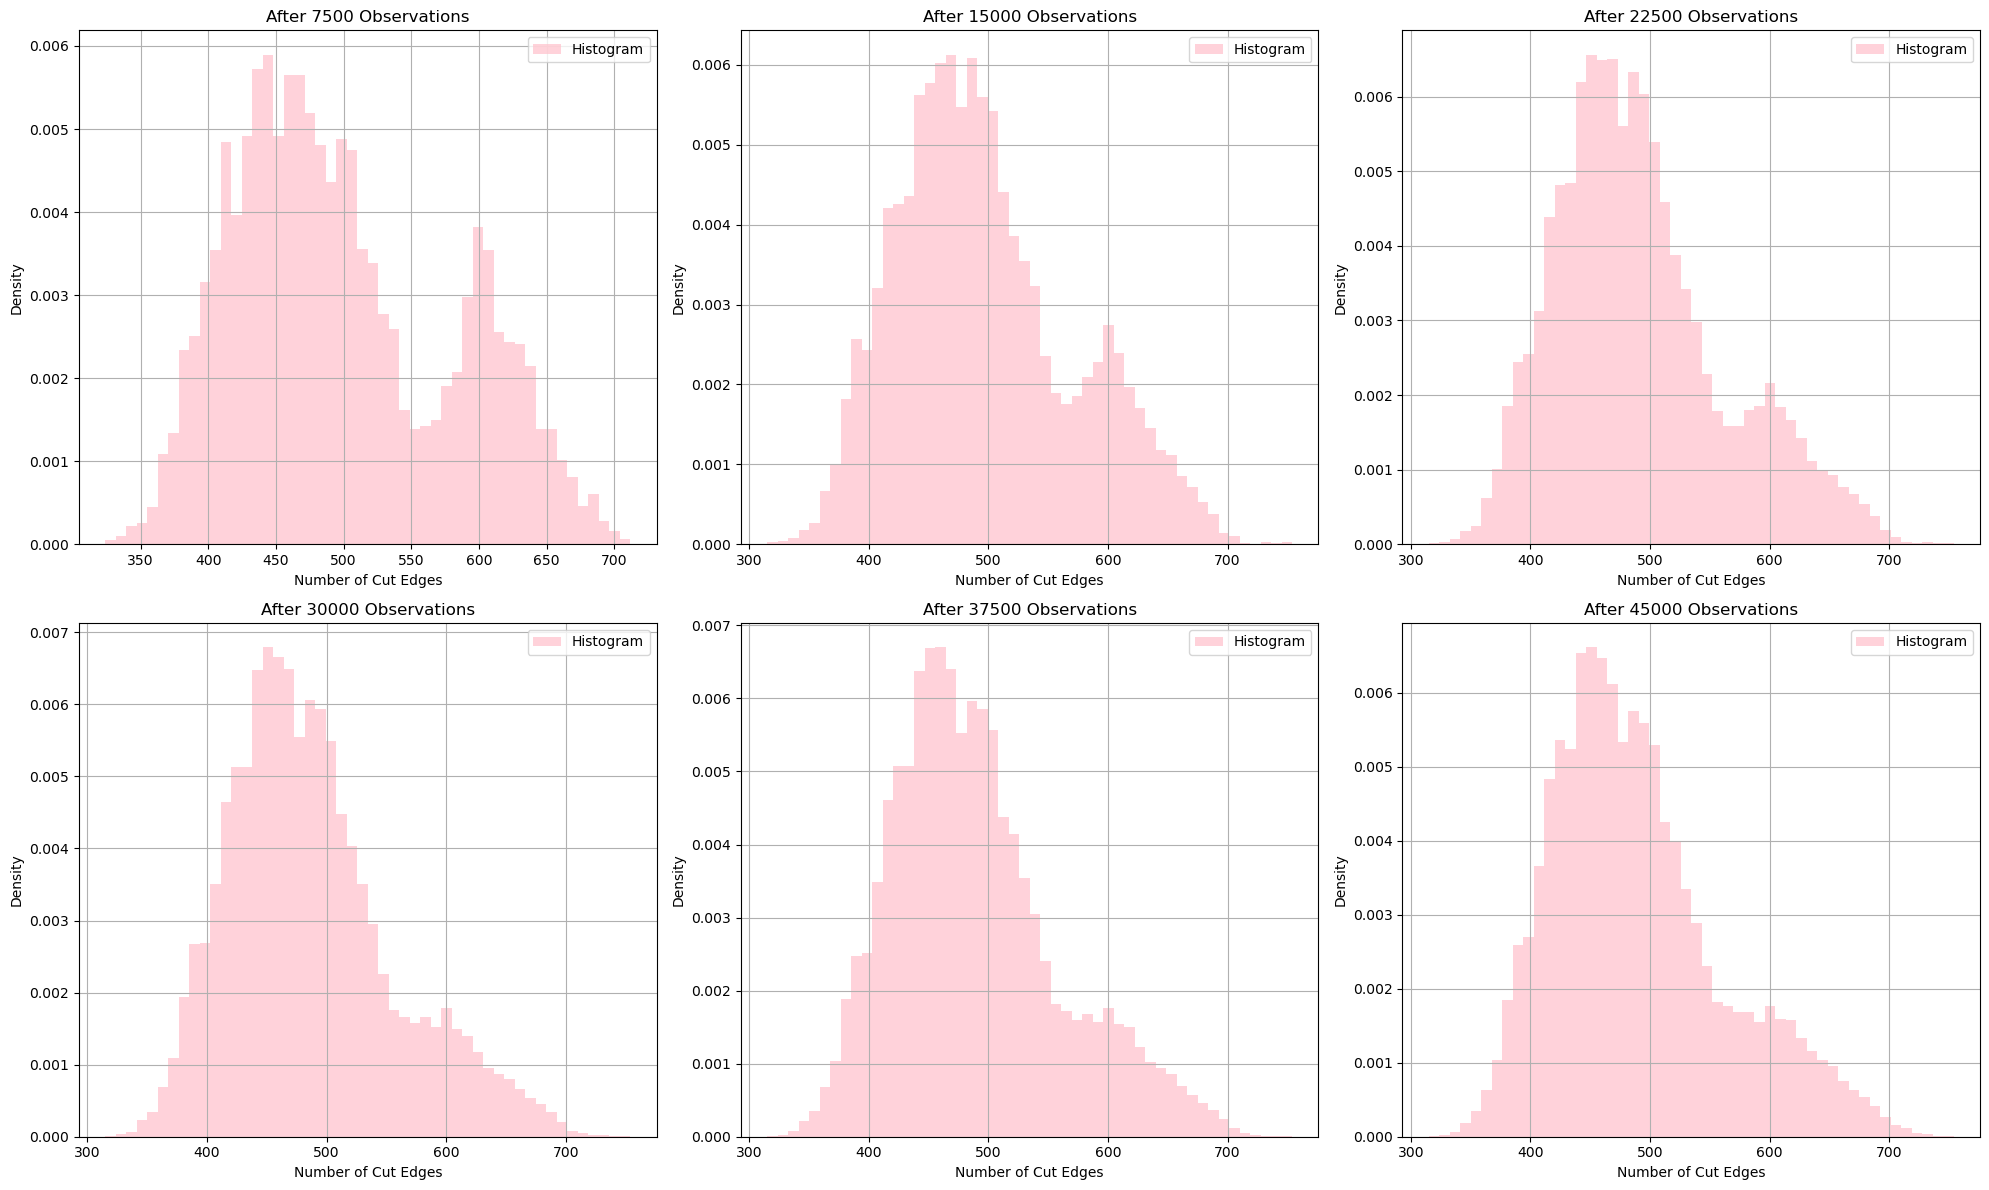

In [770]:
# Number of observations to use in each plot
step = 7500
num_plots = len(range(step, len(valid_counts) + 1, step))

# Determine the number of rows and columns for the subplots
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot the distribution for the first 5k, 10k, 15k, etc. observations
for i, ax in enumerate(axes[:num_plots]):
    iteration = (i + 1) * step
    plot_distribution(ax, valid_counts[:iteration], og_plan_cut_edges_count, min_cuts, iteration)

# Remove any unused subplots
for ax in axes[num_plots:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

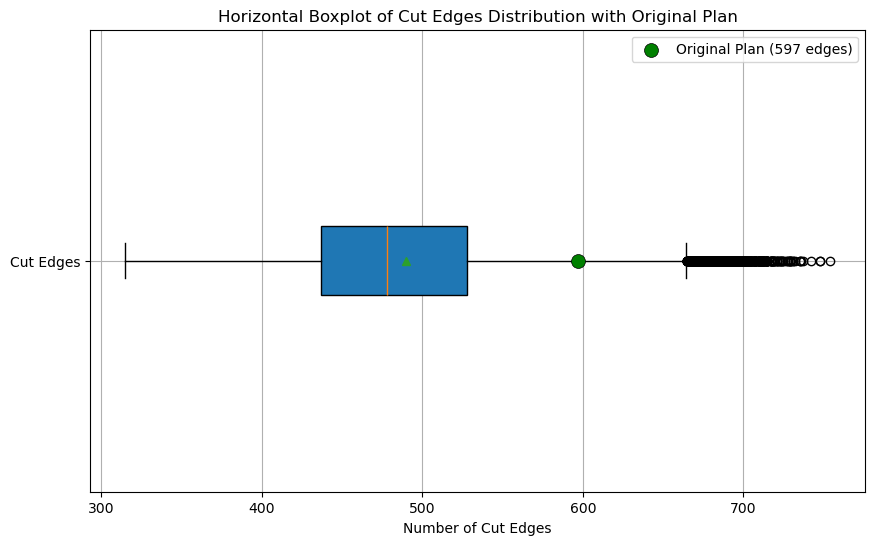

In [681]:
# Horizontal boxplot of the valid_counts
plt.figure(figsize=(10, 6))
plt.boxplot(valid_counts, patch_artist=True, vert=False, showmeans=True)

# Scatter plot for the original plan, with edge color for visibility
plt.scatter([og_plan_cut_edges_count], [1], color='green', edgecolor='black', s=100, linewidth=.5, 
            label=f'Original Plan ({og_plan_cut_edges_count} edges)', zorder=3)

# Adding labels and title
plt.title('Horizontal Boxplot of Cut Edges Distribution with Original Plan')
plt.xlabel('Number of Cut Edges')
plt.yticks([1], ['Cut Edges'])  # Customize tick labels if needed
plt.legend()
plt.grid(True)
plt.show()


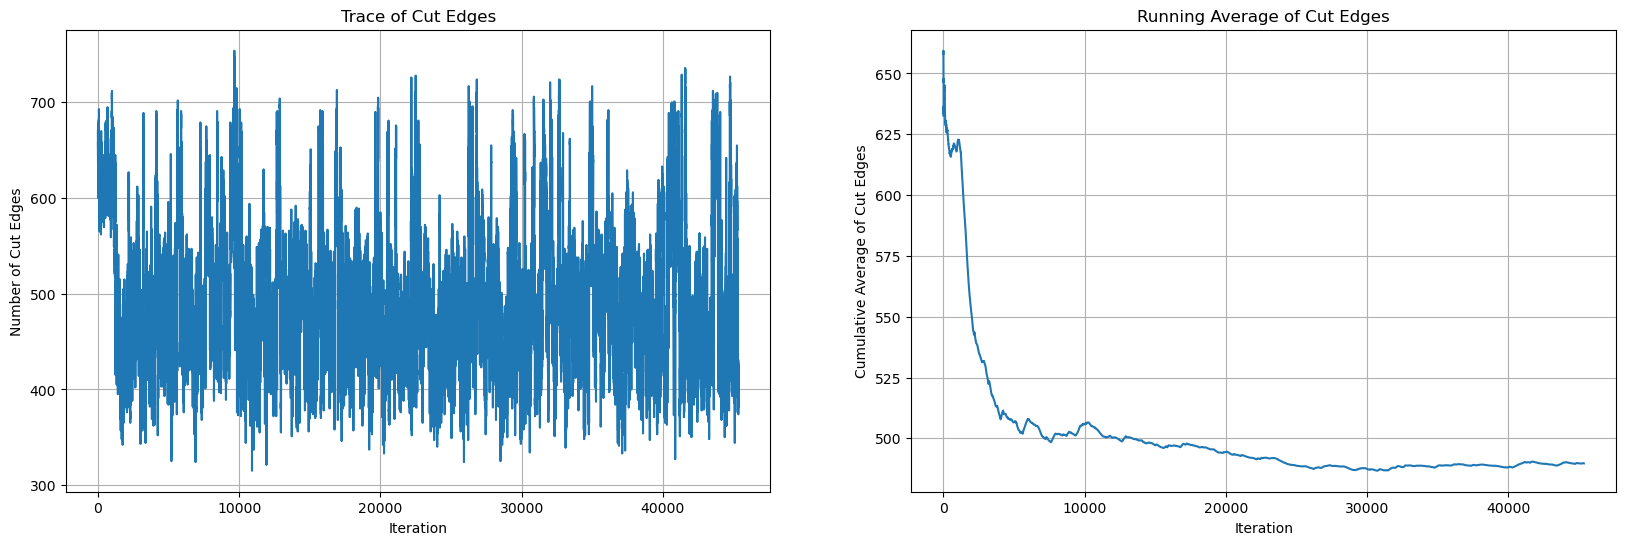

In [682]:
cut_edges = np.array([h for h in history if h is not None])

# Set up a figure to hold both plots
plt.figure(figsize=(20, 6))  # Wider figure to accommodate both subplots

# Trace plot of cut edges
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(cut_edges)
plt.title('Trace of Cut Edges')
plt.xlabel('Iteration')
plt.ylabel('Number of Cut Edges')
plt.grid(True)

# Running Average plot
cumulative_average = np.cumsum(cut_edges) / np.arange(1, len(cut_edges) + 1)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(cumulative_average)
plt.title('Running Average of Cut Edges')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Average of Cut Edges')
plt.grid(True)

# Show both plots
plt.show()


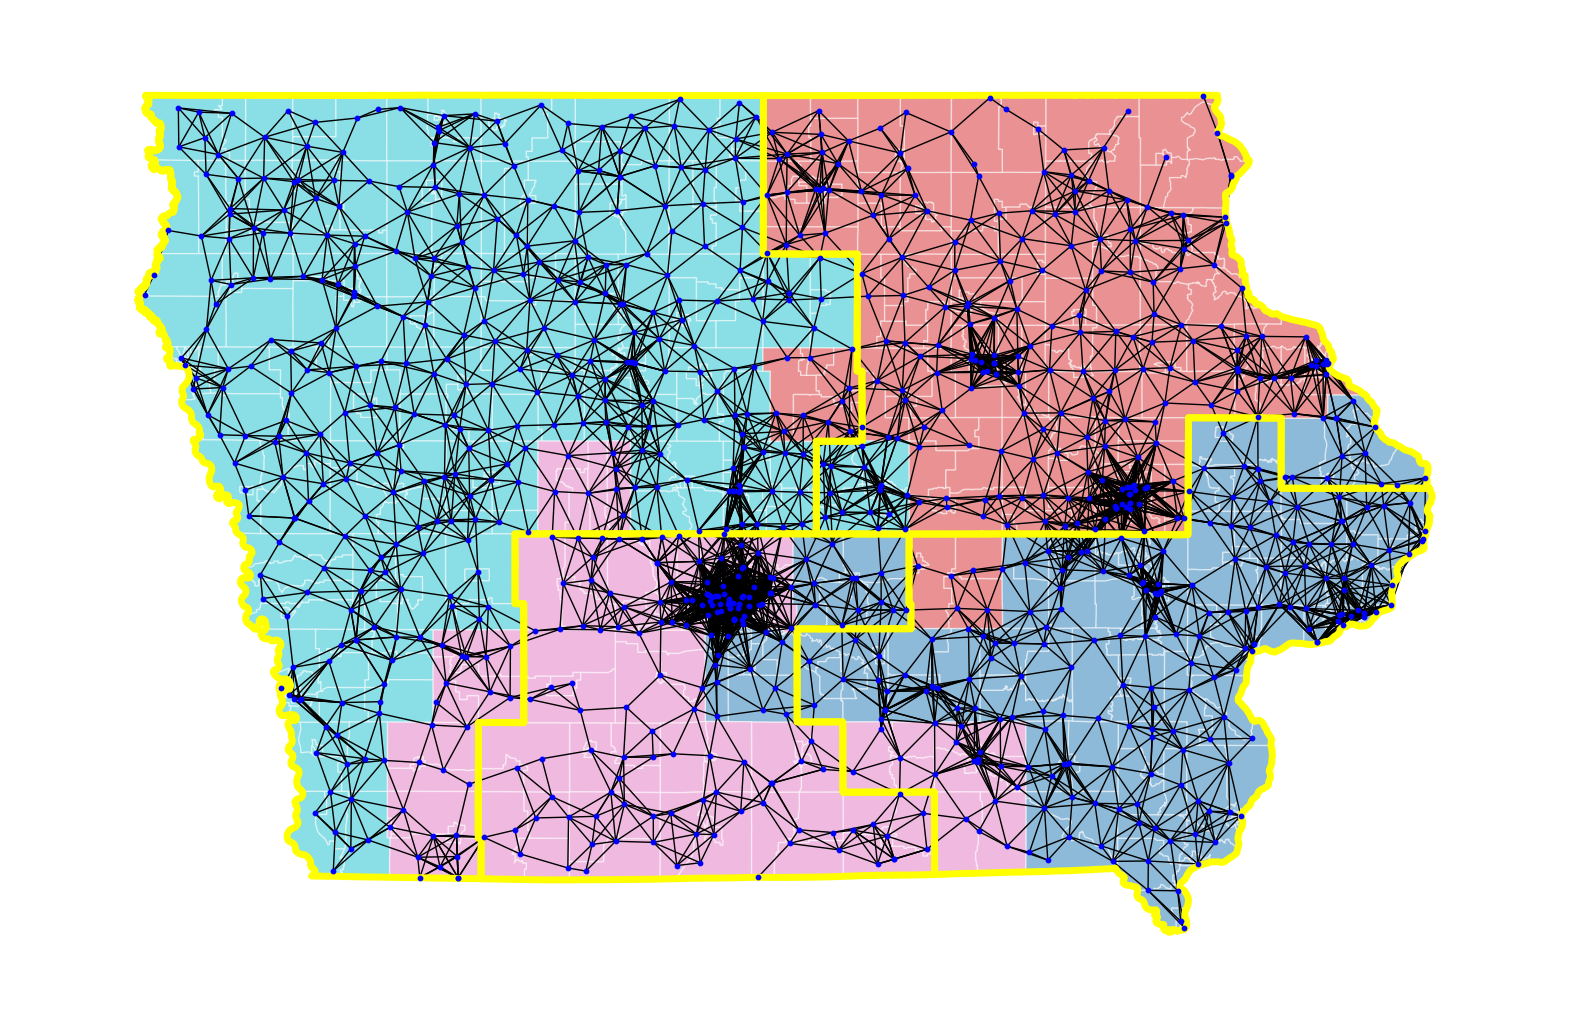

In [683]:
# Create a figure and an axes.
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the main GeoDataFrame
base = gdf.plot(ax=ax, column='district', edgecolor='white', alpha=0.5)

# Plot edges that are identified as cut
#gdf_edges.plot(ax=base, edgecolor='black')
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='black', ax=base)

# Plotting additional GeoDataFrame
best_config.plot(ax=base, column='district', edgecolor='yellow', linewidth=5, facecolor='none')

# Hide the x and y axis labels
ax.set_xticks([])  # Hide x-axis ticks
ax.set_yticks([])  # Hide y-axis ticks

# Optionally, if you want to hide the axis lines as well:
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Remove the frame of the plot
ax.set_frame_on(False)

# Set the outer background color of the axes
#fig.patch.set_facecolor('gray')  # This changes the figure background color

plt.show()

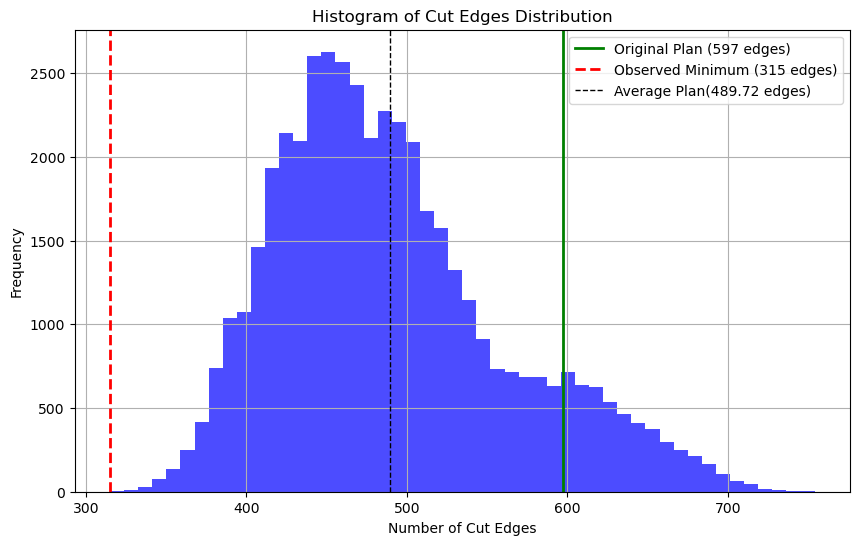

In [707]:
plt.figure(figsize=(10, 6))
plt.hist(valid_counts, bins=50, color='blue', alpha=0.7)

plt.axvline(x=og_plan_cut_edges_count, color='green', linestyle='-', linewidth=2, 
            label=f'Original Plan ({og_plan_cut_edges_count} edges)')

plt.axvline(x=min_cuts, color='red', linestyle='dashed', linewidth=2, 
            label=f'Observed Minimum ({min_cuts} edges)')

plt.axvline(x=np.mean(valid_counts), color='black', label=f'Average Plan({round(np.mean(valid_counts), 2)} edges)', 
            linestyle='dashed', linewidth=1)
plt.title('Histogram of Cut Edges Distribution')
plt.xlabel('Number of Cut Edges')
plt.ylabel('Frequency')
plt.legend()  # Add this to display the legend
plt.grid(True)
plt.show()

In [685]:
len(valid_counts)

45344

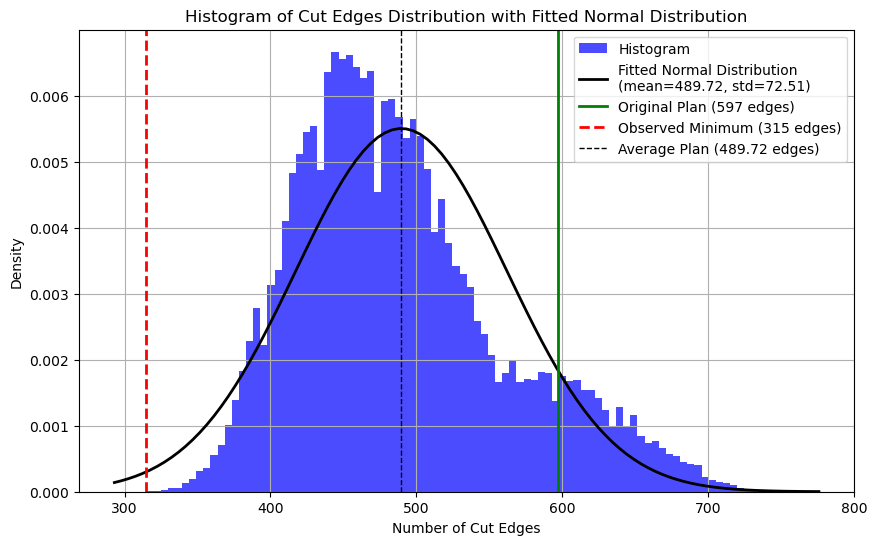

Mean: 489.72
Standard Deviation: 72.51
P(Z > Original Plan) = 0.0695


In [686]:
# Fit a normal distribution to the data
mu, std = norm.fit(valid_counts)

# Calculate the probability of choosing a plan worse than the original plan
p_value = 1 - norm.cdf(og_plan_cut_edges_count, mu, std)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(valid_counts, bins=90, density=True, color='blue', alpha=0.7, label='Histogram')

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Fitted Normal Distribution\n(mean={mu:.2f}, std={std:.2f})')

# Plot the original, minimum and average plan
plt.axvline(x=og_plan_cut_edges_count, color='green', linestyle='-', linewidth=2, 
            label=f'Original Plan ({og_plan_cut_edges_count} edges)')
plt.axvline(x=min_cuts, color='red', linestyle='dashed', linewidth=2, 
            label=f'Observed Minimum ({min_cuts} edges)')
plt.axvline(x=np.mean(valid_counts), color='black', linestyle='dashed', linewidth=1, 
            label=f'Average Plan ({round(np.mean(valid_counts), 2)} edges)')

# Add labels, title, legend, and grid
plt.title('Histogram of Cut Edges Distribution with Fitted Normal Distribution')
plt.xlabel('Number of Cut Edges')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Print the mean, variance, and p-value
print(f'Mean: {mu:.2f}')
print(f'Standard Deviation: {std:.2f}')
print(f'P(Z > Original Plan) = {p_value:.4f}')


In [534]:
calculate_cut_edges(create_districts(counties_initializer), gdf_edges.loc[unique_crossover_edges_list])

553

In [626]:
create_districts(counties).apply(lambda x: calculate_polsby_popper_score(x['geometry']), 1)

district
1    0.270416
2    0.389783
3    0.322077
4    0.260782
dtype: float64

In [624]:
(create_districts(counties))

geometry  population
district                                                               
1         POLYGON ((-91.38196 40.38763, -91.38420 40.386...      797584
2         POLYGON ((-92.76656 41.60865, -92.76657 41.612...      797589
3         POLYGON ((-93.78443 41.16208, -93.78420 41.162...      797551
4         POLYGON ((-95.38470 40.88455, -95.38470 40.882...      797645

In [625]:
100*(create_districts(counties)['population']-target_population)/target_population

district
1   -0.001034
2   -0.000407
3   -0.005172
4    0.006614
Name: population, dtype: float64

In [708]:
import numpy as np
#import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

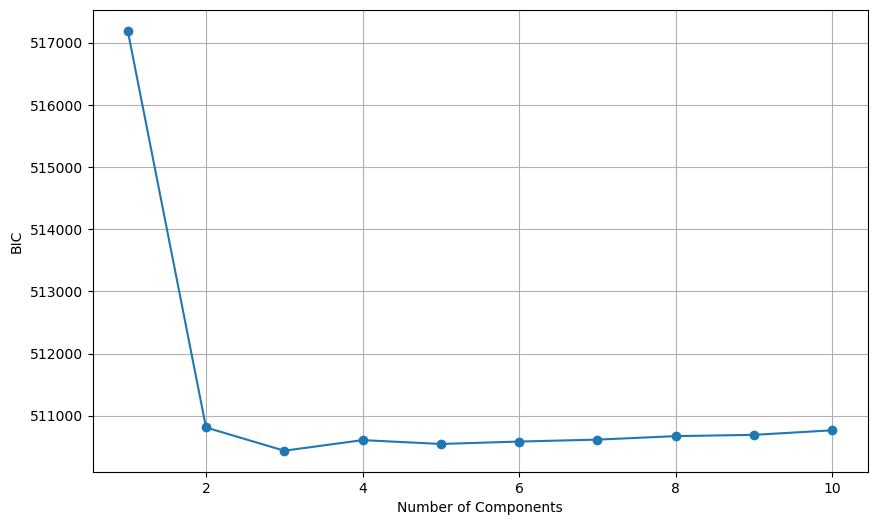

The optimal number of components is 3


In [740]:
# Function to compute BIC for different numbers of components
def compute_bic(data, max_components=10):
    bics = []
    for n_components in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(np.array(data).reshape(-1, 1))
        bics.append(gmm.bic(np.array(data).reshape(-1, 1)))
    return bics

# Compute BIC for different numbers of components
max_components = 10
bics = compute_bic(vc, max_components)

# Plot the BIC values
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), bics, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
#plt.title('BIC for Different Numbers of Gaussian Components')
plt.grid(True)
plt.show()

# Print the optimal number of components
optimal_components = np.argmin(bics) + 1
print(f'The optimal number of components is {optimal_components}')


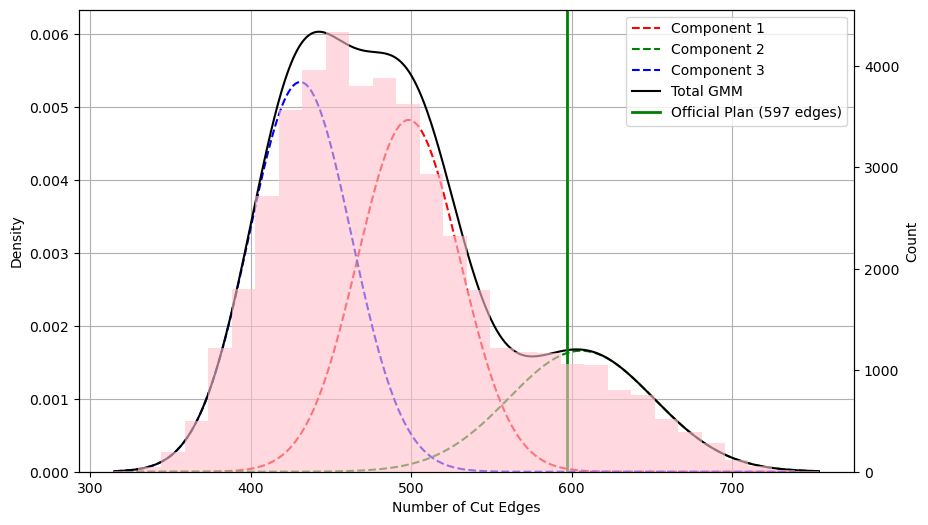

Means: [498.36825428 605.86397842 430.8148547 ]
Variances: [1013.28069746 2047.77139506 1018.73904084]


In [782]:
# Assuming valid_counts is your list of data points
vc = np.array(valid_counts).reshape(-1, 1)  # Reshape for sklearn

# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=0).fit(vc)

# Predict the component for each sample
labels = gmm.predict(vc)

# Get the means and variances of the components
means = gmm.means_.flatten()
variances = gmm.covariances_.flatten()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Gaussian components on the left y-axis
x = np.linspace(min(vc), max(vc), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
responsibilities = gmm.predict_proba(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax1.plot(x, pdf_individual[:, 0], '--r', label='Component 1')
ax1.plot(x, pdf_individual[:, 1], '--g', label='Component 2')
ax1.plot(x, pdf_individual[:, 2], '--b', label='Component 3')
ax1.plot(x, pdf, '-k', label='Total GMM')
ax1.set_xlabel('Number of Cut Edges')
ax1.set_ylabel('Density')
ax1.set_ylim(bottom=0)
#ax1.set_title('Histogram with Gaussian Mixture Model')

plt.axvline(x=og_plan_cut_edges_count, color='green', linestyle='-', linewidth=2, 
            label=f'Official Plan ({og_plan_cut_edges_count} edges)')

# Create a second y-axis on the right for the histogram
ax2 = ax1.twinx()
ax2.hist(vc, bins=30, density=False, alpha=0.6, color='pink')
ax2.set_ylabel('Count')
ax2.set_ylim(bottom=0)

# Combine legends from both y-axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

# Add grid and show plot
ax1.grid(True)
plt.show()

# Print the means and variances
print(f'Means: {means}')
print(f'Variances: {variances}')


In [790]:
weights = gmm.weights_.flatten()
weights

array([0.38466576, 0.18806542, 0.42726882])

In [762]:
# Function to plot the histogram and fitted GMM distribution
def plot_gmm_distribution(ax, valid_counts, og_plan_cut_edges_count, min_cuts, iteration):
    # Fit a Gaussian Mixture Model to the data
    gmm = GaussianMixture(n_components=3)
    gmm.fit(np.array(valid_counts).reshape(-1, 1))
    
    # Get the means and covariances of the GMM components
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    
    # Calculate the total GMM PDF
    x = np.linspace(min(valid_counts), max(valid_counts), 1000)
    total_gmm_pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))

    # Plot the histogram
    ax.hist(valid_counts, bins=50, density=True, color='pink', alpha=0.7, label='Histogram')

    # Plot the total GMM PDF
    ax.plot(x, total_gmm_pdf, 'k', linewidth=2, label='Total GMM')

    # Plot the individual GMM components with specific colors
    colors = ['red', 'blue','yellow']
    for i in range(gmm.n_components):
        component_pdf = gmm.weights_[i] * np.exp(-0.5 * ((x - means[i]) ** 2) / covariances[i]) / np.sqrt(2 * np.pi * covariances[i])
        ax.plot(x, component_pdf, linestyle='--', linewidth=2, color=colors[i], label=f'Component {i+1}')

    # Plot the original, minimum and average plan
    #ax.axvline(x=og_plan_cut_edges_count, color='green', linestyle='-', linewidth=2, 
    #           label=f'Original Plan ({og_plan_cut_edges_count} edges)')
    #ax.axvline(x=min_cuts, color='red', linestyle='dashed', linewidth=2, 
    #           label=f'Observed Minimum ({min_cuts} edges)')
    #ax.axvline(x=np.mean(valid_counts), color='black', linestyle='dashed', linewidth=1, 
    #           label=f'Average Plan ({round(np.mean(valid_counts), 2)} edges)')
    

    # Add labels, title, legend, and grid
    ax.set_title(f'After {iteration} Observations')
    ax.set_xlabel('Number of Cut Edges')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True)

In [763]:
len(valid_counts)

45344

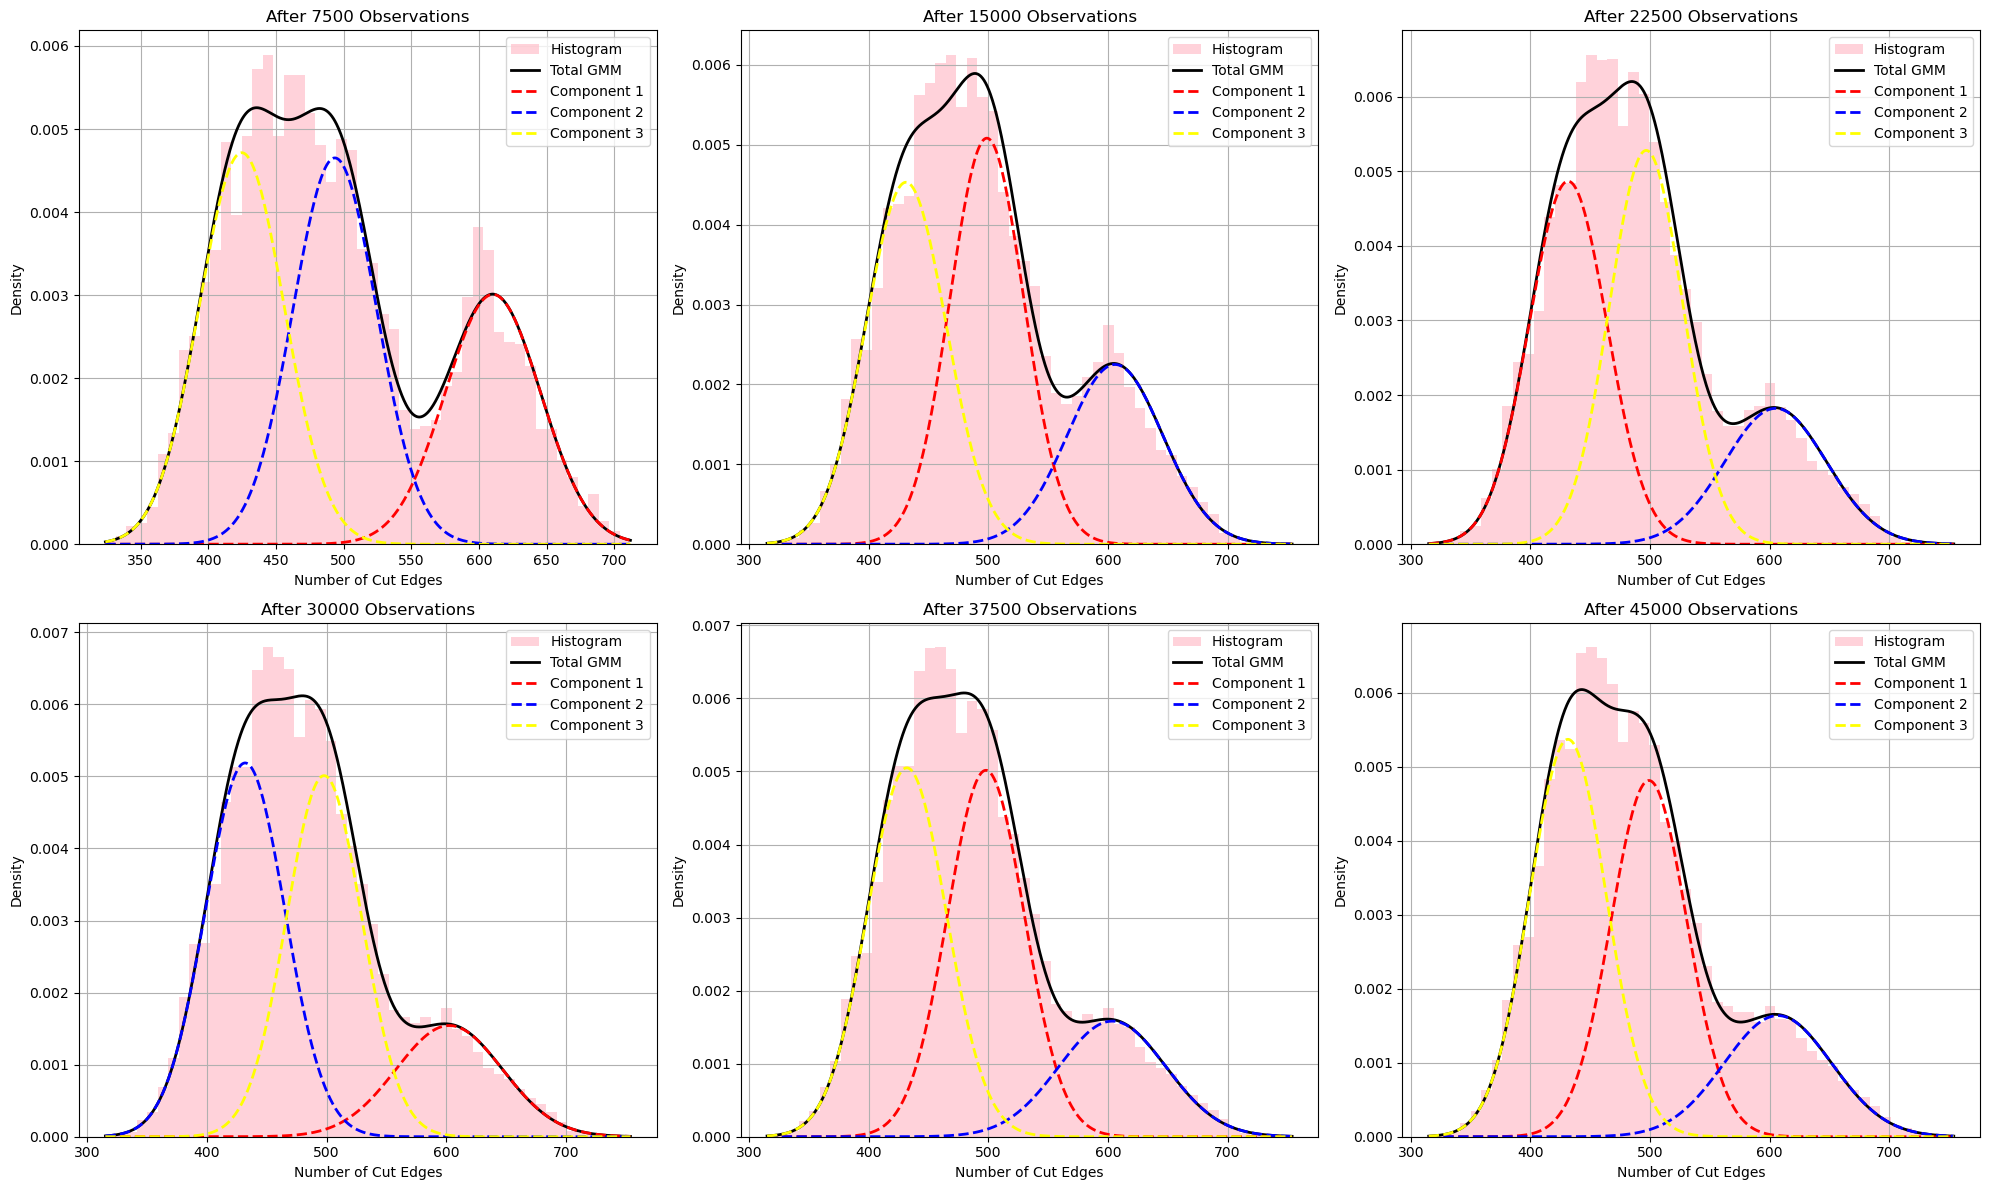

In [764]:
# Number of observations to use in each plot
step = 7500
num_plots = len(range(step, len(vc) + 1, step))

# Determine the number of rows and columns for the subplots
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot the distribution for the first 5k, 10k, 15k, etc. observations
for i, ax in enumerate(axes[:num_plots]):
    iteration = (i + 1) * step
    plot_gmm_distribution(ax, vc[:iteration], og_plan_cut_edges_count, min_cuts, iteration)

# Remove any unused subplots
for ax in axes[num_plots:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [746]:
# Assuming valid_counts is your list of sampled data points
vc = np.array(valid_counts).reshape(-1, 1)  # Reshape for sklearn

# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=0).fit(vc)

# Specific value for districting plan D
D_value = np.array([[og_plan_cut_edges_count]])

# Calculate the log likelihood of D_value under the GMM
log_likelihood = gmm.score(D_value)

# Convert log likelihood to probability
likelihood = np.exp(log_likelihood)

# Print the results
print(f"Log Likelihood of D_value (597) under the GMM: {log_likelihood:.2f}")
print(f"Likelihood of D_value (597) under the GMM: {likelihood:.4f}")


Log Likelihood of D_value (597) under the GMM: -6.40
Likelihood of D_value (597) under the GMM: 0.0017


# Generating the Adjecency Graph for later comparison

In [810]:
# Step 1: Add a column 'centroid' to the GeoDataFrame
counties['centroid'] = counties['geometry'].centroid

In [818]:
countiesCopy = counties.copy().reset_index()

In [826]:
countiesCopy.centroid.x

0    -94.470935
1    -94.699181
2    -91.378092
3    -92.868607
4    -94.905820
        ...    
94   -93.734197
95   -91.843704
96   -96.044795
97   -93.260849
98   -93.735146
Length: 99, dtype: float64

In [853]:
# Step 2: Create a NetworkX graph
A_g = nx.Graph()

# Step 3: Add nodes to the graph
for idx, row in countiesCopy.iterrows():
    A_g.add_node(idx, pos=(row['centroid'].x, row['centroid'].y)) #, county=row['COUNTYFP'])

# Step 4: Add edges to the graph
for idx1, row1 in countiesCopy.iterrows():
    for idx2, row2 in countiesCopy.iterrows():
        if idx1 < idx2:  # Check each pair only once
            intersection = row1['geometry'].intersection(row2['geometry'])
            if intersection.geom_type == 'LineString' or intersection.geom_type == 'MultiLineString':
                #print(f"Found LineString intersection between {idx1} and {idx2}")
                A_g.add_edge(idx1, idx2)
            #else:
                #print(f"Intersection between {idx1} and {idx2} is {intersection.geom_type}")

In [854]:
posi = nx.get_node_attributes(A_g, 'pos')

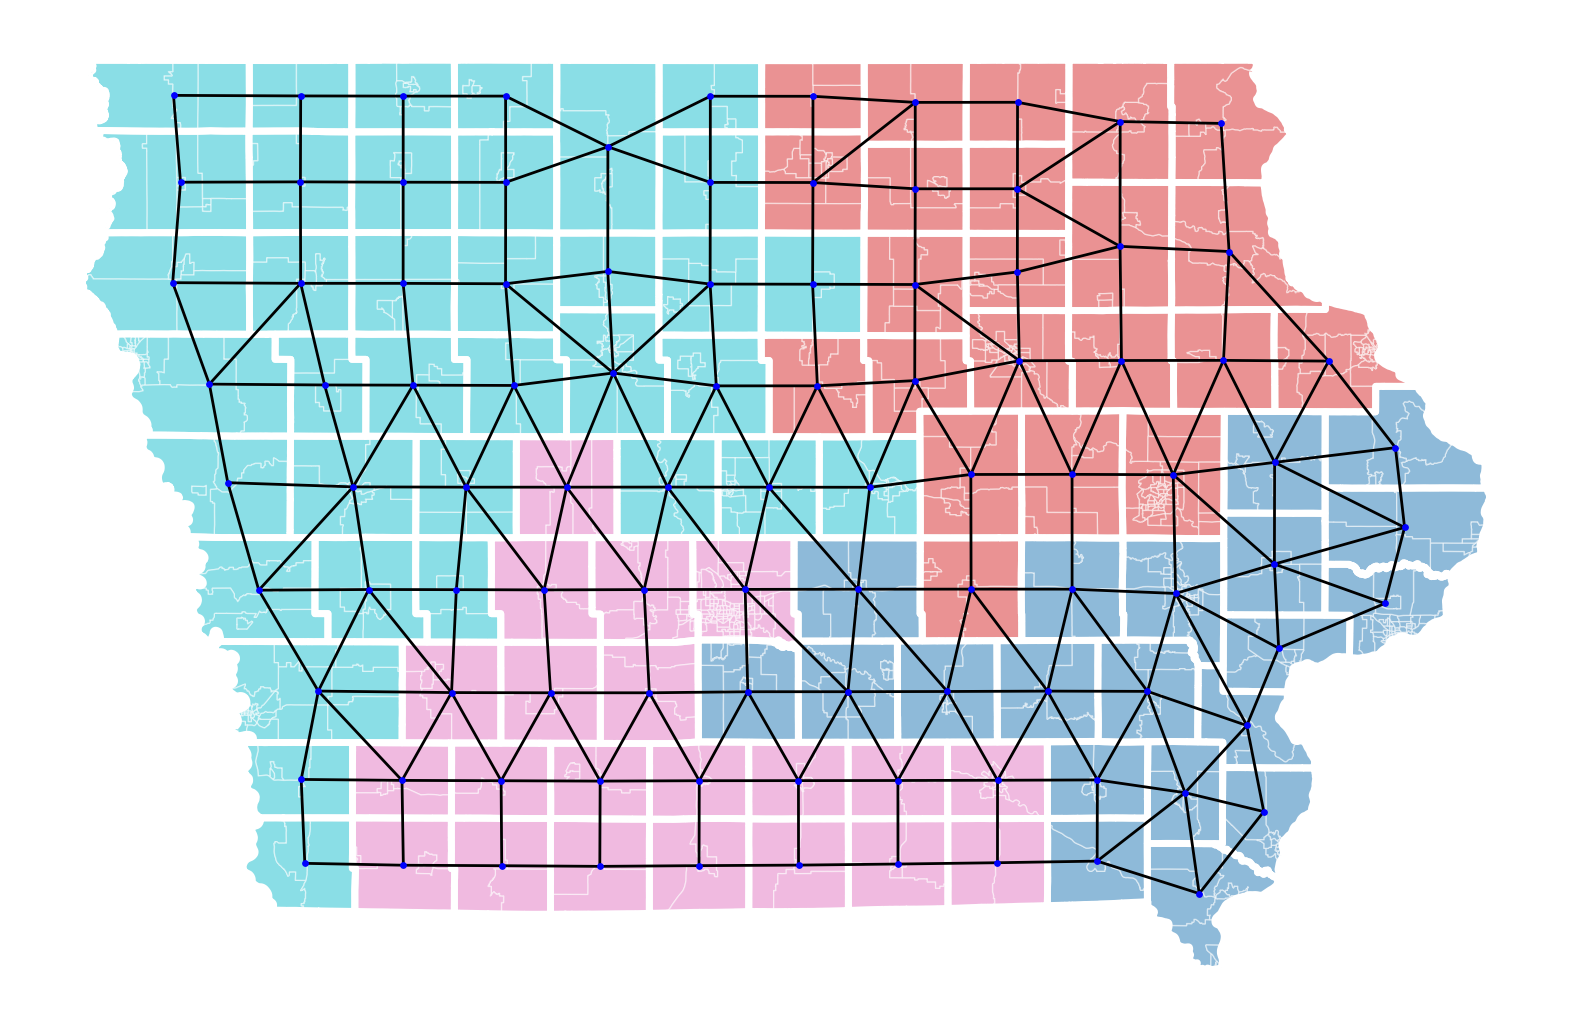

In [855]:
# Create a figure and an axes.
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the main GeoDataFrame
base = gdf.plot(ax=ax, column='district', edgecolor='white', alpha=0.5)


# Plotting additional GeoDataFrame
counties_initializer.plot(ax=base, column='district', edgecolor='white', linewidth=5, facecolor='none')

# Plot edges that are identified as cut
#gdf_edges.plot(ax=base, edgecolor='black')
nx.draw(A_g, posi, node_size=15, node_color='blue', edge_color='black', width=2, ax=base)
#gdf_points.plot(ax=base, color='black', markersize=5)


# Hide the x and y axis labels
ax.set_xticks([])  # Hide x-axis ticks
ax.set_yticks([])  # Hide y-axis ticks

# Optionally, if you want to hide the axis lines as well:
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Remove the frame of the plot
ax.set_frame_on(False)

# Set the outer background color of the axes
#fig.patch.set_facecolor('gray')  # This changes the figure background color

# Create custom legend
#legend_handles = [mpatches.Patch(color=color, label=f'District {district}') for district, color in district_colors.items()]
#ax.legend(handles=legend_handles, loc='upper right', fontsize=15)

# Add a title to the plot
#ax.set_title('Iowa District Map', fontsize=20)


plt.show()